# **Cointegration Pairs Trading Strategy in South African Consumer Cyclical Stocks**
[Thabang Ndhlovu,](http://www.linkedin.com/in/thabangndhlovu) October 2022

This notebook provides an example of the application of cointegration in a pairs trading strategy to identify mean reverting spreads in South African Consumer Cyclical Stocks. Pairs trading is a market-neutral strategy in its most primitive form. The market-neutral portfolios are constructed using two securities with an economic link, consisting of a long position in one security and a short position in the other, in a predetermined ratio. 

In [1]:
# Import modules
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import financedatabase as database
from quantstats import stats, utils, extend_pandas
extend_pandas()

## Table of Contents:
* [1: Data Analysis](#Data-Analysis)
* * [1.1: Universe Selection](#Universe-Selection)
* * * [1.1.2: Get Data](#Get-Data)
* * * [1.1.3: Selection and Filtering](#Selection-and-Filtering)
* * [1.2: Data Exploration](#Data-Exploration)
* * * [1.2.1: Index](#Index)
* * * [1.2.2: Constituents](#Constituents)
* * * [1.2.3: Visualization](#Visualization)
* [2: Statistical Checks](#Statistical-Checks)
* * [2.1 Stationarity](#Stationarity)
* * [2.2 Cointegration](#Cointegration)
* * * [2.2.1 Estimating Spread](#Estimating-Spread)
* [3: Pairs Trading](#Pairs-Trading)
 * * [3.1: Trading Strategy](#Trading-Strategy)
 * * [3.2: Algorithm](#Algorithm)
 * * [3.3: Portfolio Construction](#Portfolio-Construction)
 * * * [3.3.1: Backtest](#Backtest)
 * * * [3.3.2: Feature Engineering](#Feature-Engineering)
 * * * [3.3.3: Transformation and Factor Modelling](#Transformation-and-Factor-Modelling)
 * * * [3.3.4: Asset Allocation](#Asset-Allocation)
 * * * [3.3.5: Portfolio Analysis](#Portfolio-Analysis)
 * * [3.4: Out-of-Sample Backtest](#Out-of-Sample-Backtest)
* [4: About Me](#About-Me)
* [5: Disclosure](#Disclosure)
* [6: References](#References)

# ____

# Data Analysis

## Universe Selection

The underlying premise of pairs trading is that stocks with similar characteristics and an economic link must be priced more or less the same. On this note, our stock universe will be some of South Africa's consumer cyclical stocks listed on the Johannesburg Stock Exchange (JSE). A cyclical company is one whose earnings are highly dependent on the stage of the business cycle. These companies have high earnings volatility and high operating leverage as a result they are often a good choice for mean-reversion trading strategies. To retrieve this data we will use [financedatabase](https://github.com/JerBouma/FinanceDatabase) and [yfinance](https://github.com/ranaroussi/yfinance).

In [2]:
db = database.select_equities(country='South Africa',
                              sector='Consumer Cyclical',
                              exclude_exchanges=False)

tickers = [ticker for ticker in db if ticker.endswith('.JO')] # filter JSE stocks

In [3]:
print(f'No. of tickers: {len(tickers)}\n')
print(tickers)

No. of tickers: 36

['AON.JO', 'AOO.JO', 'BCF.JO', 'CGR.JO', 'CLH.JO', 'CMH.JO', 'CSB.JO', 'FBR.JO', 'GPL.JO', 'HIL.JO', 'ITE.JO', 'L4L.JO', 'LEW.JO', 'LUX.JO', 'MPT.JO', 'MRP.JO', 'MSM.JO', 'MTA.JO', 'MTH.JO', 'NCS.JO', 'NPK.JO', 'PIK.JO', 'PPH.JO', 'RTN.JO', 'RTO.JO', 'SHFF.JO', 'SHP.JO', 'SNH.JO', 'SUI.JO', 'SUR.JO', 'TFG.JO', 'TGO.JO', 'TPC.JO', 'TRU.JO', 'TSG.JO', 'WHL.JO']


### Get Data

In [4]:
# download data
start = '2010-01-01'
end = '2021-12-31'

data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  36 of 36 completed

2 Failed downloads:
- L4L.JO: No timezone found, symbol may be delisted
- TGO.JO: No timezone found, symbol may be delisted


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3082 entries, 2010-01-01 00:00:00 to 2021-12-30 00:00:00
Columns: 216 entries, ('Adj Close', 'AON.JO') to ('Volume', 'WHL.JO')
dtypes: float64(187), int64(29)
memory usage: 5.1+ MB


### Selection and filtering

In this section, we will clean and filter our data for analysis. To do this, we will first drop any illiquid stocks. Specifically, we will drop any stock whose volume was less than 1000 and was not traded more than 50 times in the given period. Additionally, we will drop stocks that are highly volatile, as measured by their volatility, maximum drawdown, and returns.

*You can adjust the permeters to you liking....*

In [6]:
# study period
start = '2014-01-01'
end = '2014-12-31' 
data.index = pd.to_datetime(data.index)

# drop illiquid stocks
volume = data['Volume'].loc[start:end]
stocks = data['Adj Close'].loc[start:end]
drop_illiquid = volume.T[np.sum(volume > 1e5) < 50].index
stocks.drop(drop_illiquid, axis=1, inplace=True)

# drop highly volatile stocks
vol = [idx for idx, val in enumerate(stocks.volatility()) if val > 1]
mxd = [idx for idx, val in enumerate(stocks.max_drawdown()) if val < -1]
ret = [idx for idx, val in enumerate(stocks.to_returns().comp()) if val > 5]

drop_idx = np.unique([vol + mxd + ret])
drop_vol = [stocks.columns[idx] for idx in drop_idx]
stocks.drop(drop_vol, axis=1, inplace=True)

In [7]:
tickers = list(stocks.columns)
print(f'No. of tickers: {len(tickers)} (after clean up...)\n')
print(tickers)

No. of tickers: 19 (after clean up...)

['CGR.JO', 'CLH.JO', 'FBR.JO', 'GPL.JO', 'ITE.JO', 'LEW.JO', 'MPT.JO', 'MRP.JO', 'MSM.JO', 'MTA.JO', 'NPK.JO', 'PIK.JO', 'SHP.JO', 'SNH.JO', 'SUI.JO', 'TFG.JO', 'TRU.JO', 'TSG.JO', 'WHL.JO']


We lost a sufficient amount of tickers, but at least we can start working...

## Data Exploration

### Index

In [8]:
index = pd.DataFrame(stocks.sum(axis=1), columns=['Index']) # equally weighted

**Risk and Return Metrics**

In [9]:
index

Index
Date                     
2014-01-01   93403.628601
2014-01-02   93472.028198
2014-01-03   92601.592407
2014-01-06   91822.641968
2014-01-07   92237.276276
...                   ...
2014-12-25  111616.742828
2014-12-26  111616.742828
2014-12-29  113592.236786
2014-12-30  113111.827301
2014-12-31  113693.795959

[261 rows x 1 columns]

In [10]:
def performance_metrics(df):
    '''Returns risk and return metrics for the given stock''' 
    data = []
    metrics = ['Expected Returns', 'Cummulative Returns', 'Volatility',
               'Sharpe Ratio','Sortino Ratio', 'Information Ratio',
               'Skewness', 'Max Drawdown', 'CVaR at 95%','Pay-Off Ratio']
    
    for x in pd.concat([df]):
        data.append((
            df[x].to_returns().compsum().mean(), df[x].to_returns().comp(), 
            df[x].volatility(), df[x].sharpe(), df[x].sortino(), 
            df[x].information_ratio(index), df[x].skew(), df[x].max_drawdown(), 
            df[x].cvar(), df[x].payoff_ratio()
        ))
    return pd.DataFrame(data, df.columns, metrics)

In [11]:
index_metrics = performance_metrics(index.rebase())
index_metrics

Expected Returns  Cummulative Returns  Volatility  Sharpe Ratio  \
Index          0.062715             0.217231    0.135733      1.466372   

       Sortino Ratio  Information Ratio  Skewness  Max Drawdown  CVaR at 95%  \
Index       2.262092          -0.022565  -0.11976     -0.100846    -0.017851   

       Pay-Off Ratio  
Index       1.120613

### Constituents

In [12]:
stocks

CGR.JO       CLH.JO        FBR.JO      GPL.JO      ITE.JO  \
Date                                                                    
2014-01-01   630.0  2354.455566   8451.443359  289.315247  532.949585   
2014-01-02   649.0  2303.183594   8447.031250  286.873779  532.949585   
2014-01-03   637.0  2289.016602   8384.368164  286.873779  532.949585   
2014-01-06   640.0  2284.174805   8477.038086  286.263428  542.819092   
2014-01-07   645.0  2293.401367   8654.436523  281.407318  560.443054   
...            ...          ...           ...         ...         ...   
2014-12-25  1275.0  2114.149658  10038.168945  427.258881  720.776062   
2014-12-26  1275.0  2114.149658  10038.168945  427.258881  720.776062   
2014-12-29  1335.0  2117.459961  10055.485352  427.258881  702.756592   
2014-12-30  1410.0  2092.020020  10004.443359  427.258881  720.776062   
2014-12-31  1425.0  2093.588135  10514.875000  424.207031  720.776062   

                 LEW.JO       MPT.JO        MRP.JO        MSM.JO       MTA.JO  \
Date                                                                            
2014-01-01  3458.002930  2032.031616  12159.323242  11279.852539  2875.089355   
2014-01-02  3387.769287  2021.456299  12104.370117  11279.852539  2889.613281   
2014-01-03  3377.527100  2047.140137  11965.502930  11019.547852  2904.864014   
2014-01-06  3412.155762  2039.585693  11899.412109  10797.421875  3002.903564   
2014-01-07  3436.541748  2039.585693  11865.995117  10944.927734  2999.272461   
...                 ...          ...           ...           ...          ...   
2014-12-25  4030.617920  2827.430908  17423.546875  12911.297852  2364.067627   
2014-12-26  4030.617920  2827.430908  17423.546875  12911.297852  2364.067627   
2014-12-29  4068.027100  2827.430908  18048.351562  13007.282227  2378.842529   
2014-12-30  4004.273682  2835.978027  17814.906250  13052.134766  2366.283691   
2014-12-31  3899.425781  2855.402100  17927.810547  12809.931641  2360.373291   

                 NPK.JO       PIK.JO        SHP.JO       SNH.JO       SUI.JO  \
Date                                                                           
2014-01-01  3642.685791  3987.539551  13029.907227  4117.118652  7187.683594   
2014-01-02  3678.224609  3995.207275  13149.085938  4165.469238  7193.716797   
2014-01-03  3635.578369  3987.539551  12990.977539  4135.364258  7188.437988   
2014-01-06  3616.032227  3926.959229  12870.211914  4127.154297  7021.755859   
2014-01-07  3634.689941  3880.182373  12849.553711  4166.382324  7089.634766   
...                 ...          ...           ...          ...          ...   
2014-12-25  4006.506104  4001.600586  13252.728516  5546.749023  9586.867188   
2014-12-26  4006.506104  4001.600586  13252.728516  5546.749023  9586.867188   
2014-12-29  4015.727295  4134.208008  13640.072266  5633.859863  9664.001953   
2014-12-30  4020.337646  4147.467773  13751.557617  5623.444824  9603.064453   
2014-12-31  4022.181885  4104.565918  13690.526367  5624.391602  9942.452148   

                 TFG.JO       TRU.JO       TSG.JO       WHL.JO  
Date                                                            
2014-01-01  6077.184570  4463.176758  1574.598999  5261.270020  
2014-01-02  6038.467773  4448.058594  1565.719727  5335.978516  
2014-01-03  5965.477539  4434.104980  1561.575928  5257.746094  
2014-01-06  5807.438477  4357.934570  1533.162231  5180.218750  
2014-01-07  5796.649902  4360.842773  1539.081909  5199.247559  
...                 ...          ...          ...          ...  
2014-12-25  8857.853516  4663.423828  1766.642212  5802.057129  
2014-12-26  8857.853516  4663.423828  1766.642212  5802.057129  
2014-12-29  9052.540039  4727.163574  1771.552856  5985.215820  
2014-12-30  8784.762695  4771.291016  1777.077515  5904.749023  
2014-12-31  8853.204102  4736.356445  1780.146851  5908.581055  

[261 rows x 19 columns]

**Risk and Return Metrics**

In [13]:
stocks_metrics = performance_metrics(stocks)
stocks_metrics.sort_values('Sharpe Ratio', ascending=False)

Expected Returns  Cummulative Returns  Volatility  Sharpe Ratio  \
CGR.JO          0.262438             1.261905    0.353922      2.404803   
SUI.JO          0.157184             0.383262    0.202673      1.646620   
TFG.JO          0.186586             0.456794    0.242758      1.618009   
GPL.JO          0.293302             0.466245    0.249871      1.603439   
MRP.JO          0.144339             0.474409    0.261838      1.562713   
MPT.JO          0.150562             0.405196    0.247130      1.452383   
SNH.JO          0.191963             0.366099    0.230249      1.424406   
ITE.JO          0.154961             0.352428    0.248780      1.295611   
FBR.JO          0.081767             0.244151    0.228585      1.036557   
TSG.JO          0.026092             0.130540    0.202273      0.686763   
WHL.JO          0.022289             0.123033    0.246124      0.578699   
MSM.JO          0.035028             0.135647    0.283982      0.574288   
LEW.JO         -0.053423             0.127653    0.302634      0.533638   
NPK.JO         -0.003854             0.104180    0.250366      0.506745   
TRU.JO          0.002288             0.061207    0.259783      0.349902   
SHP.JO         -0.039665             0.050700    0.236006      0.319566   
PIK.JO          0.039587             0.029348    0.226781      0.235856   
CLH.JO         -0.101373            -0.110797    0.208753     -0.439199   
MTA.JO         -0.016819            -0.179026    0.248256     -0.645106   

        Sortino Ratio  Information Ratio  Skewness  Max Drawdown  CVaR at 95%  \
CGR.JO       4.172846           0.110959  1.631025     -0.124166    -0.060311   
SUI.JO       2.859246           0.042570  0.003568     -0.087427    -0.025369   
TFG.JO       2.541811           0.069673  0.261436     -0.118255    -0.029030   
GPL.JO       2.711148           0.046813 -0.135029     -0.127742    -0.031741   
MRP.JO       2.432718           0.074826  0.128940     -0.198070    -0.032148   
MPT.JO       2.328434           0.039549  0.334794     -0.115371    -0.031267   
SNH.JO       2.060685           0.037382 -0.219182     -0.179828    -0.037088   
ITE.JO       2.062424           0.027605  0.139360     -0.090909    -0.039510   
FBR.JO       1.653141           0.010506  0.453647     -0.175304    -0.033335   
TSG.JO       1.002213          -0.018602  0.399092     -0.107725    -0.036075   
WHL.JO       0.787976          -0.018931 -0.572796     -0.221107    -0.035832   
MSM.JO       0.844203          -0.010235 -0.262304     -0.206177    -0.044425   
LEW.JO       0.795790          -0.008354  1.134252     -0.196952    -0.042440   
NPK.JO       0.755676          -0.021175  0.104527     -0.158249    -0.036638   
TRU.JO       0.517641          -0.032123  0.367244     -0.245608    -0.037008   
SHP.JO       0.474872          -0.045637 -0.101180     -0.237735    -0.035928   
PIK.JO       0.347407          -0.047394 -0.591622     -0.169344    -0.030967   
CLH.JO      -0.615095          -0.081062  0.259695     -0.183381    -0.027854   
MTA.JO      -1.052403          -0.093186 -0.346497     -0.341163    -0.031863   

        Pay-Off Ratio  
CGR.JO       1.319569  
SUI.JO       1.351561  
TFG.JO       0.995541  
GPL.JO       1.299031  
MRP.JO       1.102294  
MPT.JO       1.044097  
SNH.JO       1.113237  
ITE.JO       1.120880  
FBR.JO       1.107117  
TSG.JO       1.027435  
WHL.JO       0.916715  
MSM.JO       1.154311  
LEW.JO       1.054250  
NPK.JO       1.192762  
TRU.JO       0.971830  
SHP.JO       1.131586  
PIK.JO       0.936633  
CLH.JO       0.875156  
MTA.JO       1.413162

### Visualization

In [14]:
import seaborn as sns
import matplotlib as mpl

colors = ['gray','lightgray','b']
colormap = mpl.colors.LinearSegmentedColormap.from_list('', colors)
plt.rcParams['figure.dpi'] = 140
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

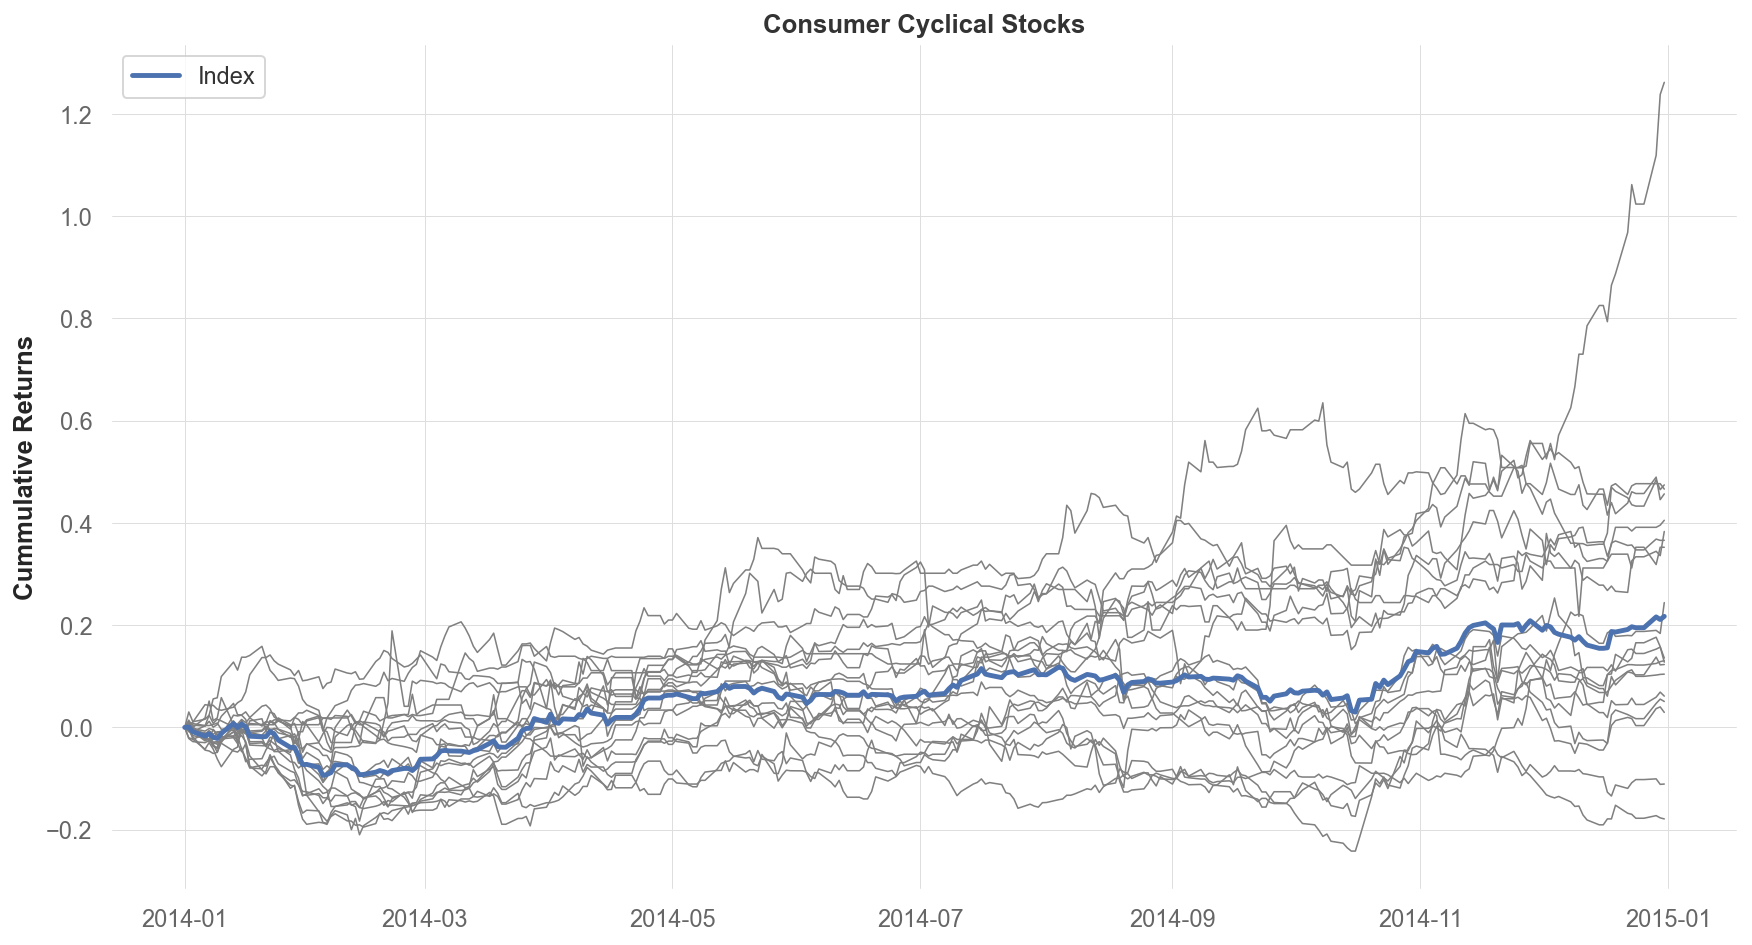

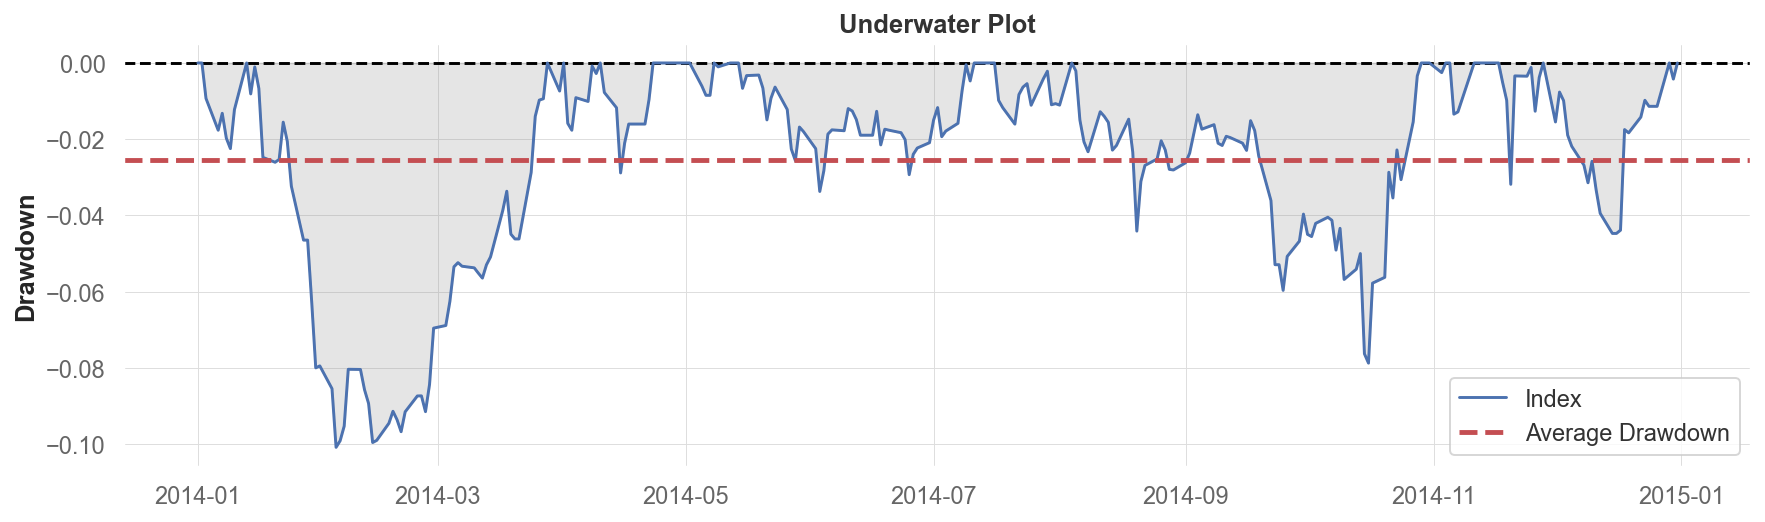

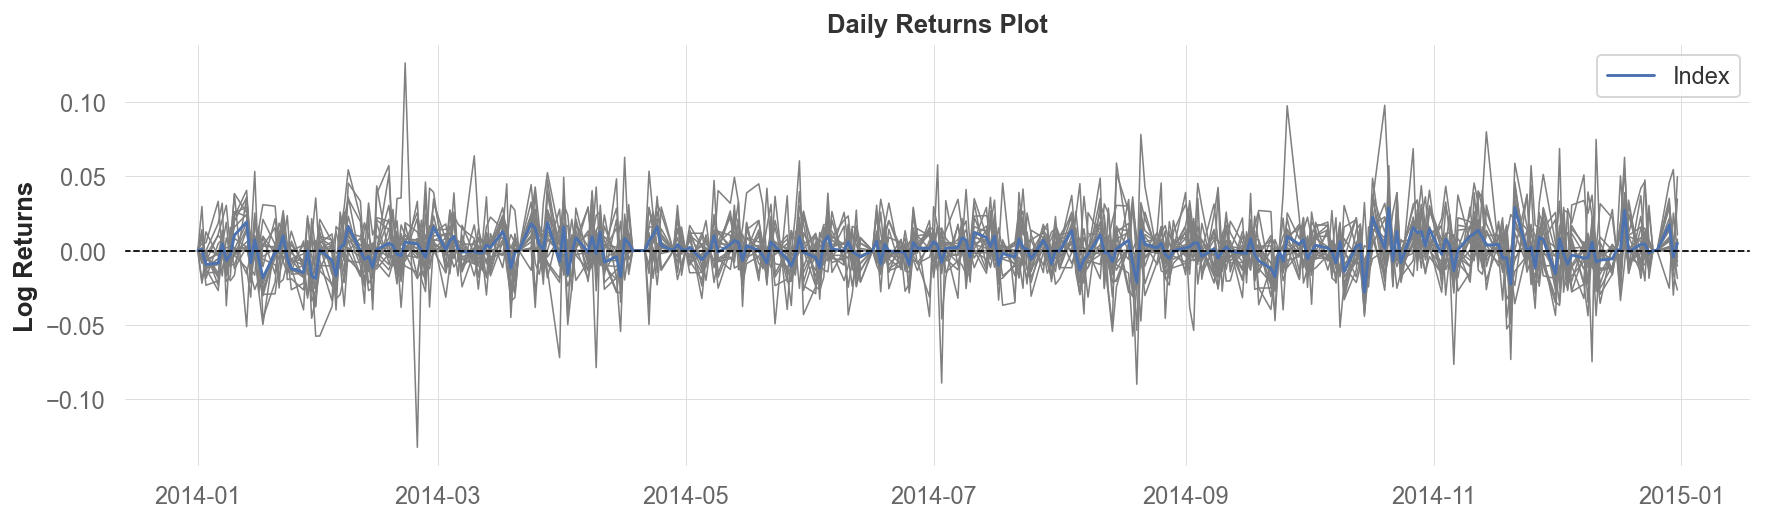

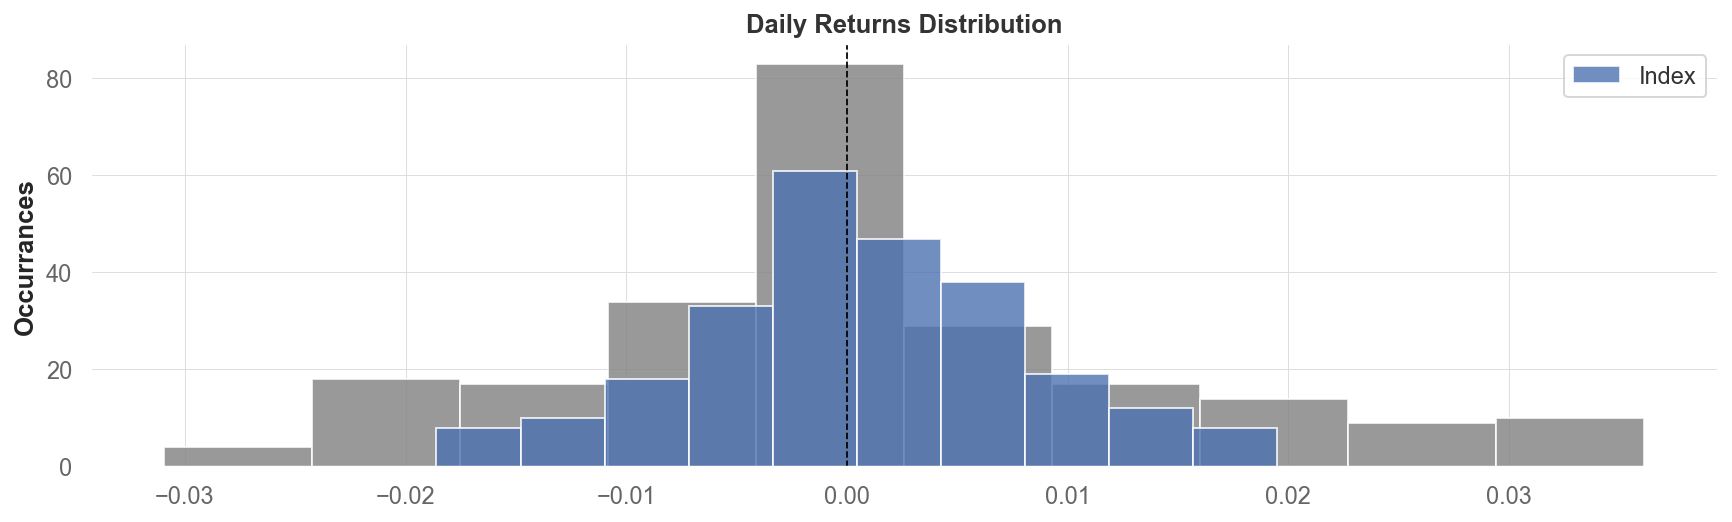

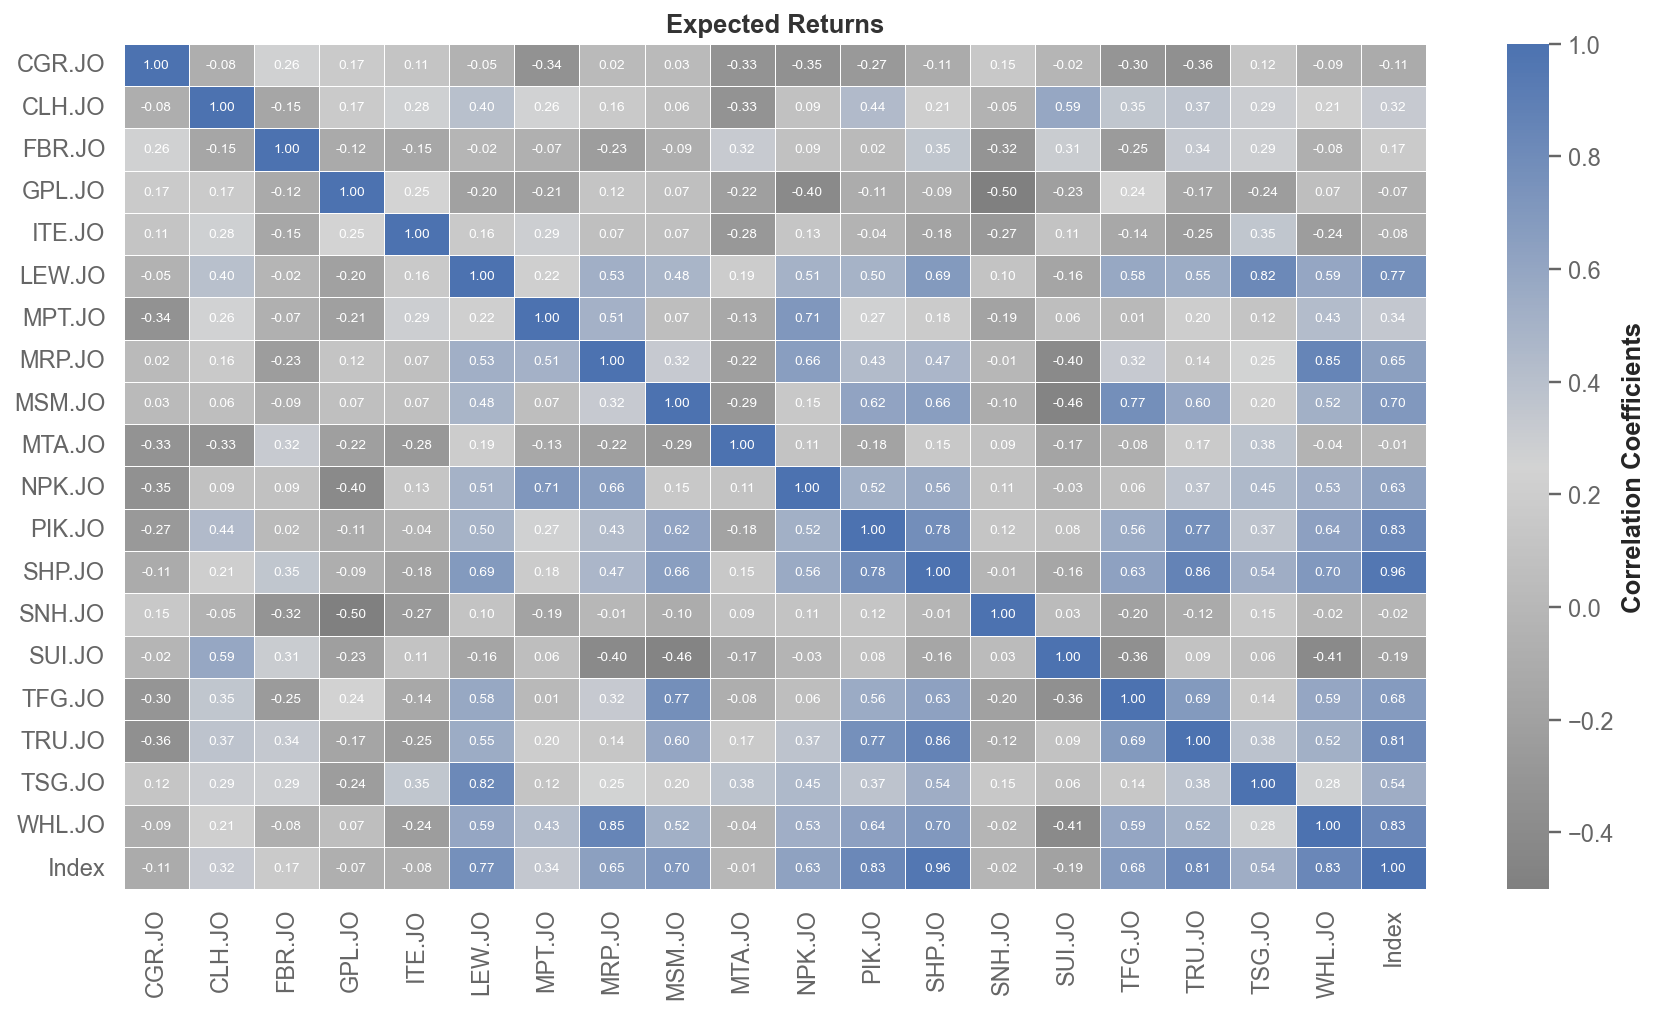

In [15]:
# line plot
plt.figure(figsize=(15, 8))
plt.title('Consumer Cyclical Stocks')
plt.plot(stocks.to_returns().compsum(), c='gray', lw=0.8)
plt.plot(index.to_returns().compsum(), label='Index', c='b', lw=2.5)
plt.ylabel('Cummulative Returns'), plt.legend()

# underwater plot
plt.figure(figsize=(15, 4))
plt.title('Underwater Plot')
plt.axhline(0, color='black', ls='--')
plt.plot(stocks.sum(axis=1).to_drawdown_series(), c='gray', lw=0.8)
plt.plot(index.to_drawdown_series(), label='Index', c='b')
plt.fill_between(stocks.sum(axis=1).to_drawdown_series().index, 
                 stocks.sum(axis=1).to_drawdown_series(), alpha=0.2, 
                 color='gray'), plt.ylabel('Drawdown'),
plt.axhline(stocks.sum(axis=1).to_drawdown_series().mean(), color='r',
           lw=2.5, ls='--', label='Average Drawdown'), plt.legend()

# returns plot
plt.figure(figsize=(15, 4))
plt.title('Daily Returns Plot')
plt.plot(stocks.log_returns(), c='gray', lw=0.8)
plt.plot(index.log_returns(), label='Index', c='b')
plt.axhline(0, ls='--', lw=0.9, c='black')
plt.ylabel('Log Returns'), plt.legend()

# histogram
plt.figure(figsize=(15, 4))
plt.title('Daily Returns Distribution')
plt.axvline(0, ls='--', lw=0.9, c='black')
plt.hist(stats.distribution(stocks)['Daily']['values'], alpha=.8, color='gray')
plt.hist(stats.distribution(index)['Daily']['values'], alpha=.8, color='b', 
         label='Index'), plt.ylabel('Occurrances'), plt.legend()

# heatmap
stocks_index = pd.concat([stocks, index], axis=1)
monthly_ret = utils.group_returns(stocks_index.to_returns(),[index.index.month]) 
plt.figure(figsize=(15, 8)), plt.title('Expected Returns')
sns.heatmap(monthly_ret.corr(), cmap=colormap, annot=True, fmt='.2f', 
            linewidth=0.5, annot_kws={'fontsize':7, 'color':'white'},
           cbar_kws={'label':'Correlation Coefficients'});

# ____

# Statistical Checks

## Stationarity

A process is said to be stationary if aspects of its behavior are unchanged by shifts in time. Mathematically, stationarity is defined as the requirement that for every $m$ and $n$, the distributions of $(Y_1, \dots Y_n)$ and $(Y_1+m, \dots Y_n+n)$ are the same, that is, the probability distribution of a sequence of $n$  does not depend on their time origin. Many statistical tests, require that the data being tested are stationary. One way to get stationary time-series is by taking difference between points in time-series. This time difference is called rate of change.

### Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

**Augmented Dickey-Fuller Test**

*'The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation. The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above a critical size, then we cannot reject that there is a unit root'*

## Cointegration

Cointegration is a statistical property of two or more time-series variables which indicates if a linear combination of the variables is stationary. In general we're just trying to solve for the coefficients $b_1, \dots b_k$ that will produce an $I(0)$ linear combination. If our best guess for these coefficients does not pass a stationarity check, then we reject the hypothesis that the set is cointegrated. 

In practice a common way to do this for pairs of time series is to use linear regression to estimate $\beta$ in the following model.

$$X_2 = \alpha + \beta X_1 + \epsilon$$

The idea is that if the two are cointegrated we can remove $X_2$'s depedency on $X_1$, leaving behind stationary noise. 

The combination $X_2 - \beta X_1 = \alpha + \epsilon$ should be stationary.

For the cointegration model to apply, we would require the logarithm of stock prices to be a nonstationary series. The assumption that the logarithm of stock prices is a random walk (read as nonstationary) is a rather standard one.

**Engle-Granger two-step test**

The method to test if two series are co-integrated is called Engle-Granger Test. Luckily there are some pre-built tests for cointegration. Here's one. Read up on the [documentation](http://statsmodels.sourceforge.net/devel/_modules/statsmodels/tsa/stattools.html).

*'The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship... If the two series are almost perfectly collinear, then computing the test is numerically unstable. However, the two series will be cointegrated under the maintained assumption that they are integrated. In this case the t-statistic will be set to -inf and the pvalue to zero.'*

In [16]:
from statsmodels.tsa.api import adfuller, coint
from itertools import permutations

def get_coint_pairs(df, p_level=5e-2):
    '''Uses Engle-Granger two-step test to get cointegrated stock pairs'''
    p_value = {}
    pairs = list(permutations(df.columns, 2))
    for x, y in pairs:
        p_value[x, y] = coint(np.log(df[x]), np.log(df[y]))[1]
    coint_pairs = [pair for pair, val in p_value.items() if val <= p_level]
    return p_value, coint_pairs

In [17]:
p_values, coint_pairs = get_coint_pairs(stocks)

In [18]:
print(f'No. of Cointergted Pairs: {len(coint_pairs)}\n')
print(coint_pairs)

No. of Cointergted Pairs: 47

[('CLH.JO', 'CGR.JO'), ('CLH.JO', 'FBR.JO'), ('CLH.JO', 'GPL.JO'), ('CLH.JO', 'ITE.JO'), ('CLH.JO', 'LEW.JO'), ('CLH.JO', 'MPT.JO'), ('CLH.JO', 'MRP.JO'), ('CLH.JO', 'MSM.JO'), ('CLH.JO', 'MTA.JO'), ('CLH.JO', 'NPK.JO'), ('CLH.JO', 'PIK.JO'), ('CLH.JO', 'SHP.JO'), ('CLH.JO', 'SNH.JO'), ('CLH.JO', 'SUI.JO'), ('CLH.JO', 'TFG.JO'), ('CLH.JO', 'TRU.JO'), ('CLH.JO', 'TSG.JO'), ('CLH.JO', 'WHL.JO'), ('FBR.JO', 'LEW.JO'), ('FBR.JO', 'MSM.JO'), ('FBR.JO', 'SHP.JO'), ('FBR.JO', 'TRU.JO'), ('GPL.JO', 'MTA.JO'), ('ITE.JO', 'MPT.JO'), ('ITE.JO', 'MRP.JO'), ('ITE.JO', 'MTA.JO'), ('ITE.JO', 'NPK.JO'), ('ITE.JO', 'SUI.JO'), ('MPT.JO', 'ITE.JO'), ('MPT.JO', 'MTA.JO'), ('MPT.JO', 'NPK.JO'), ('MRP.JO', 'ITE.JO'), ('MTA.JO', 'ITE.JO'), ('MTA.JO', 'MPT.JO'), ('MTA.JO', 'MRP.JO'), ('MTA.JO', 'NPK.JO'), ('NPK.JO', 'ITE.JO'), ('NPK.JO', 'MPT.JO'), ('NPK.JO', 'MRP.JO'), ('NPK.JO', 'MTA.JO'), ('NPK.JO', 'SUI.JO'), ('SHP.JO', 'FBR.JO'), ('SNH.JO', 'CGR.JO'), ('SUI.JO', 'ITE.JO'), (

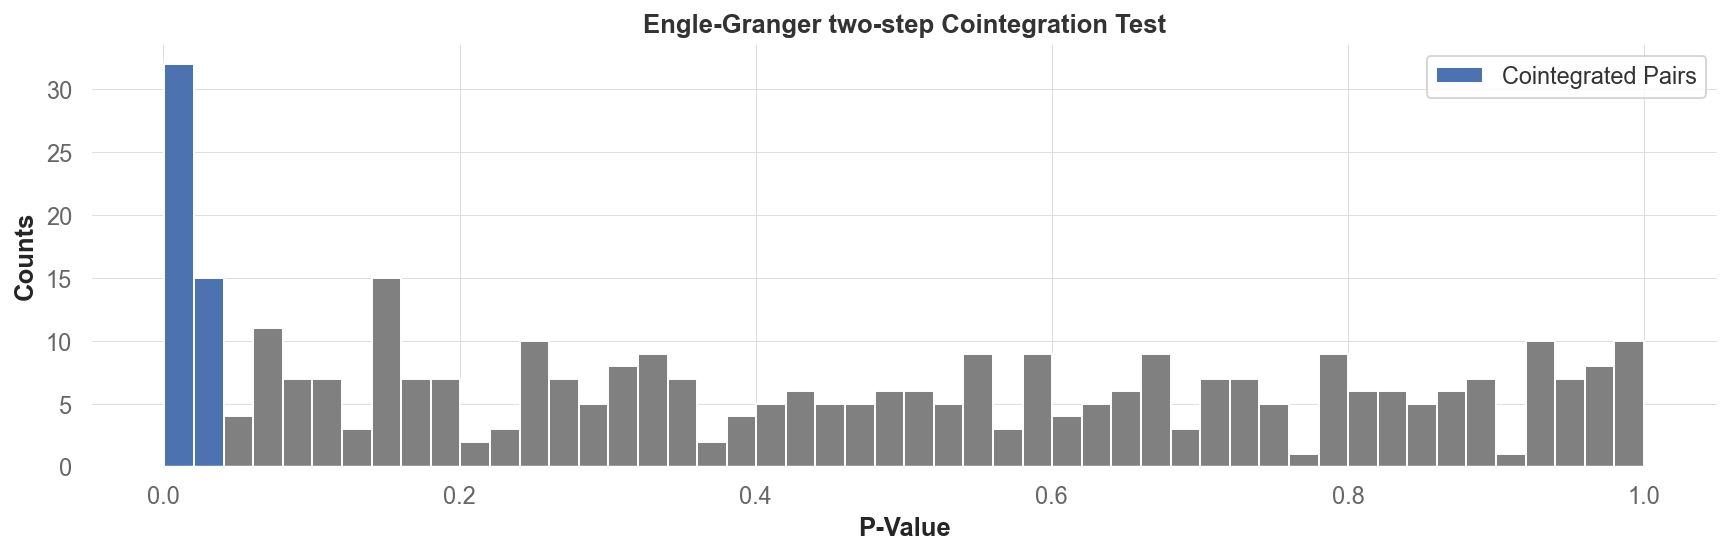

In [19]:
# histogram plot
bins_n, p_level = 50, 5e-2
counts, bins = np.histogram([p_values[x, y] for x, y in p_values], bins_n)
bins = bins[bins <= p_level]
counts = counts[:len(bins)]

plt.figure(figsize=(15, 4))
plt.title('Engle-Granger two-step Cointegration Test')
plt.hist([p_values[x, y] for x, y in p_values], bins_n, color='gray')
plt.hist(bins, bins, weights=counts, color='b', label='Cointegrated Pairs')
plt.ylabel('Counts'), plt.xlabel('P-Value'), plt.legend();

### Estimating Spread

In [20]:
from scipy.stats import zscore, linregress
def get_spread(df, coint_pairs):
    '''Computes stock pairs spread using linear regression method'''
    spread = {}
    for x, y in coint_pairs:
        lr = linregress(np.log(df[x]), np.log(df[y]))
        spread_ = df[y] - (df[x] * lr.intercept + lr.slope)
        spread[x, y] = zscore(spread_) # z-score the spread
    return pd.DataFrame(spread)

In [21]:
spread = get_spread(stocks, coint_pairs)

In [22]:
spread.describe().T.round(6)

count  mean       std       min       25%       50%       75%  \
CLH.JO CGR.JO  261.0   0.0  1.001921 -3.381923 -0.398479  0.082676  0.645874   
       FBR.JO  261.0   0.0  1.001921 -3.882826 -0.716528  0.065808  0.669295   
       GPL.JO  261.0   0.0  1.001921 -3.651339 -0.343746  0.168710  0.658910   
       ITE.JO  261.0   0.0  1.001921 -3.512255 -0.298896  0.110199  0.636667   
       LEW.JO  261.0   0.0  1.001921 -1.677712 -0.642554 -0.165447  0.395920   
       MPT.JO  261.0   0.0  1.001921 -2.737893 -0.651244  0.157235  0.788369   
       MRP.JO  261.0  -0.0  1.001921 -1.647643 -0.951804 -0.099387  0.754827   
       MSM.JO  261.0   0.0  1.001921 -2.548454 -0.554841  0.020677  0.712032   
       MTA.JO  261.0  -0.0  1.001921 -2.790263 -0.697462 -0.169454  0.723903   
       NPK.JO  261.0  -0.0  1.001921 -2.521270 -0.700103  0.157571  0.763725   
       PIK.JO  261.0   0.0  1.001921 -2.629102 -0.500454 -0.034978  0.686074   
       SHP.JO  261.0  -0.0  1.001921 -1.928549 -0.789360 -0.027813  0.777027   
       SNH.JO  261.0  -0.0  1.001921 -3.648657 -0.353163  0.148224  0.695653   
       SUI.JO  261.0  -0.0  1.001921 -2.393071 -0.767889  0.088366  0.934022   
       TFG.JO  261.0   0.0  1.001921 -2.056172 -0.617584  0.065944  0.504295   
       TRU.JO  261.0   0.0  1.001921 -2.873791 -0.611303  0.093944  0.642758   
       TSG.JO  261.0  -0.0  1.001921 -3.417974 -0.432829  0.027949  0.692621   
       WHL.JO  261.0  -0.0  1.001921 -2.580348 -0.652581  0.076599  0.787873   
FBR.JO LEW.JO  261.0  -0.0  1.001921 -2.368041 -0.762272 -0.106165  0.597968   
       MSM.JO  261.0  -0.0  1.001921 -2.662895 -0.589840  0.036045  0.500734   
       SHP.JO  261.0   0.0  1.001921 -2.405492 -0.749061  0.035726  0.866573   
       TRU.JO  261.0  -0.0  1.001921 -2.957930 -0.473111  0.132855  0.712045   
GPL.JO MTA.JO  261.0   0.0  1.001921 -1.886135 -0.984437  0.048708  0.888290   
ITE.JO MPT.JO  261.0  -0.0  1.001921 -1.539350 -0.923164 -0.524030  1.035780   
       MRP.JO  261.0   0.0  1.001921 -1.646384 -0.937375 -0.080018  0.774798   
       MTA.JO  261.0   0.0  1.001921 -1.754295 -1.022917  0.188196  1.049798   
       NPK.JO  261.0  -0.0  1.001921 -2.051557 -0.811853 -0.062125  0.853234   
       SUI.JO  261.0  -0.0  1.001921 -1.669667 -0.995797 -0.062340  0.965696   
MPT.JO ITE.JO  261.0   0.0  1.001921 -1.697128 -1.022349  0.533874  0.865423   
       MTA.JO  261.0  -0.0  1.001921 -1.614575 -1.044824  0.518358  0.899631   
       NPK.JO  261.0  -0.0  1.001921 -1.897320 -1.056767  0.519472  0.832538   
MRP.JO ITE.JO  261.0  -0.0  1.001921 -1.945881 -0.765537  0.066583  0.920657   
MTA.JO ITE.JO  261.0   0.0  1.001921 -1.671779 -0.870470 -0.171232  0.807569   
       MPT.JO  261.0  -0.0  1.001921 -1.654459 -0.867750 -0.104676  0.854378   
       MRP.JO  261.0   0.0  1.001921 -1.667942 -0.897147  0.013965  0.911155   
       NPK.JO  261.0  -0.0  1.001921 -1.665190 -0.850672 -0.088337  0.857693   
NPK.JO ITE.JO  261.0  -0.0  1.001921 -1.783652 -0.904692 -0.145811  0.955482   
       MPT.JO  261.0   0.0  1.001921 -1.710858 -0.921960 -0.175046  0.982189   
       MRP.JO  261.0  -0.0  1.001921 -1.708258 -0.823269 -0.356454  0.911509   
       MTA.JO  261.0  -0.0  1.001921 -1.926811 -0.962409  0.139510  0.902630   
       SUI.JO  261.0   0.0  1.001921 -1.623082 -1.019158  0.006037  0.983133   
SHP.JO FBR.JO  261.0   0.0  1.001921 -1.896058 -0.836481 -0.058162  0.874954   
SNH.JO CGR.JO  261.0  -0.0  1.001921 -2.236353 -0.428848  0.076287  0.408277   
SUI.JO ITE.JO  261.0   0.0  1.001921 -1.527426 -1.071890 -0.047348  1.002167   
TRU.JO FBR.JO  261.0   0.0  1.001921 -2.769930 -0.393034 -0.000552  0.620045   
       SHP.JO  261.0  -0.0  1.001921 -2.169990 -0.723254 -0.039721  0.539251   
WHL.JO TFG.JO  261.0   0.0  1.001921 -2.160627 -0.691571  0.110985  0.652749   

                    max  
CLH.JO CGR.JO  2.172031  
       FBR.JO  2.589532  
       GPL.JO  1.841619  
       ITE.JO  2.189713  
       LEW.JO  3.051843  
       MPT.JO  1.7

From the table above, it looks like our spread is stationary. Essentially, we want any deviations from the mean to revert back to be mean and looking at the 50 percentile column that is the case, meaning at the 50 percentile the spread is near the mean.

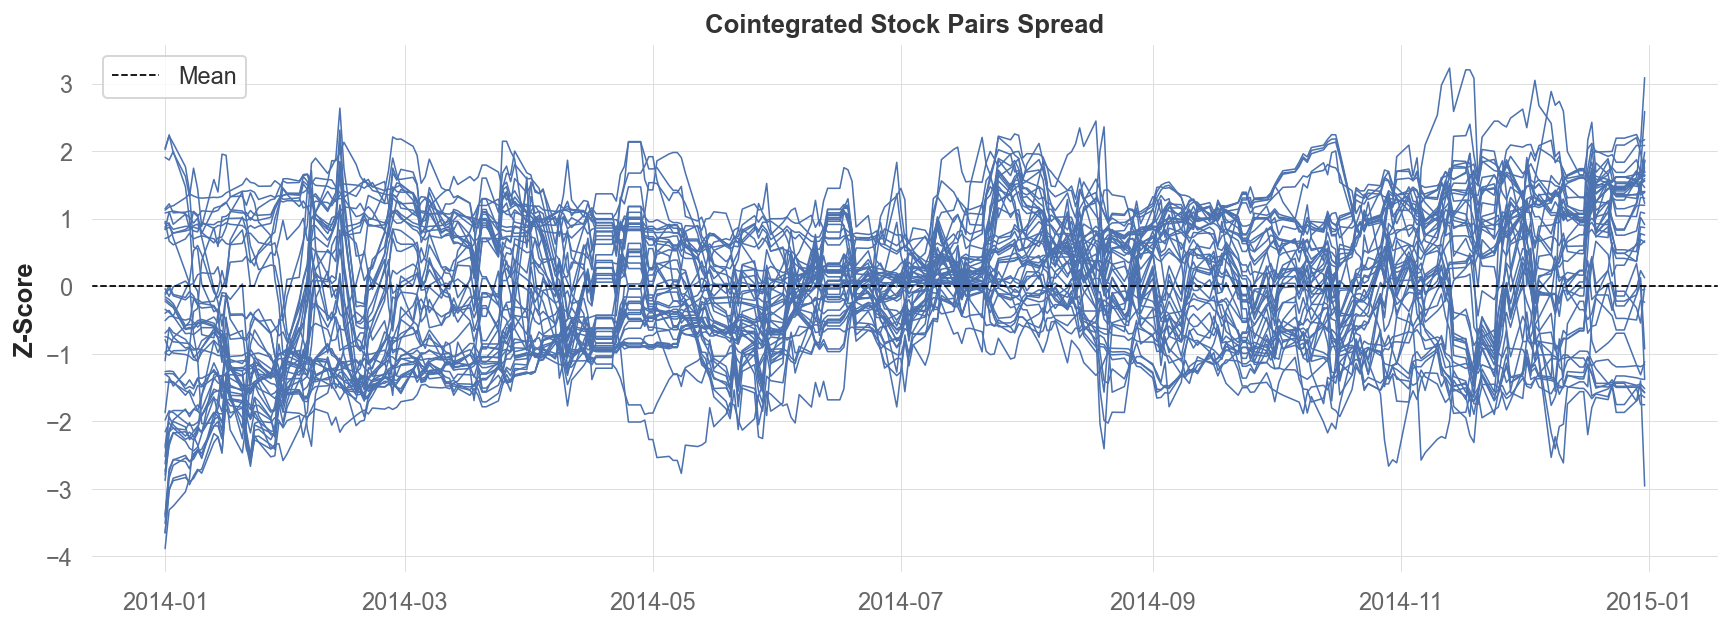

In [23]:
# line plot 
plt.figure(figsize=(15, 5))
plt.title('Cointegrated Stock Pairs Spread')
plt.plot(spread, c='b', lw=0.8)
plt.axhline(0, ls='--', lw=0.9, c='black', label='Mean')
plt.ylabel('Z-Score'), plt.legend();

# ____

# Pairs Trading

## Trading Strategy

To create a trading strategy using cointegration, we first identify the equilibrium value of the spread between the two securities. We enter a trade when the spread deviates from this equilibrium value and exit the trade when the spread returns to equilibrium. However, it is also important to note that the equilibrium value is also the mean value of the time series. This means that the spread will oscillate around its mean value, swinging equally in both directions. Therefore, it may be beneficial to close the trade when the spread deviates in the opposite direction from the initial trade.

With this in mind, we can consider a strategy where trades are entered and exited based on deviation in either direction from the long-run equilibrium value. For example, we could buy the portfolio (long Stock X and short Stock Y) when the time series $z_i$ is below the mean and sell the portfolio (long Stock Y and short Stock X) when the time series is above the mean at time step 𝑖. In other words, we will buy the spread when the z-score is below -1 and sell the spread when the z-score is above 1, and close trades when the z-score is 0.

In [24]:
def zscore_spread_plot(spread, pairs, title=None, n=5, trading_days=200):
    '''Plots trades on the speard and z-score''' 
    z_score = spread[pairs].rolling(n).mean().dropna()
    in_market, position = False, None
    
    plt.figure(figsize=(15, 2))
    default_title = f'Pairs Trading\nWith {n} Day Rolling Mean Spread\n{pairs}' 
    plt.title(default_title if title is None else title)
    plt.plot(z_score, c='b'), plt.axhline(0, ls='--', c='black')
    plt.axhline(-1, c='g'), plt.axhline(1, c='r')
    
    for i in range(trading_days):
        # Sell the spread
        if z_score[i] >= 1 and not in_market: 
            sell = plt.scatter(z_score.index[i], z_score[i], marker='v', c='r', s=70)
            in_market, position = True, 'Sell'
        elif z_score.values[i] <= 0 and in_market and position is 'Sell':
            close = plt.scatter(z_score.index[i], z_score[i], marker='s', c='y', s=70)
            in_market = False
        
        # Buy the spread    
        elif z_score[i] <= -1 and not in_market:  
            buy = plt.scatter(z_score.index[i], z_score[i], marker='^', c='g', s=70)
            in_market, position = True, 'Buy'
        elif z_score[i] >= 0 and in_market and position is 'Buy':
            close = plt.scatter(z_score.index[i], z_score[i], marker='s', c='y', s=70)
            in_market = False
    
    plt.legend([sell, buy, close], ['Sell Spread','Buy Spread','Close'], loc=2), 
    plt.ylabel('Z-Score')

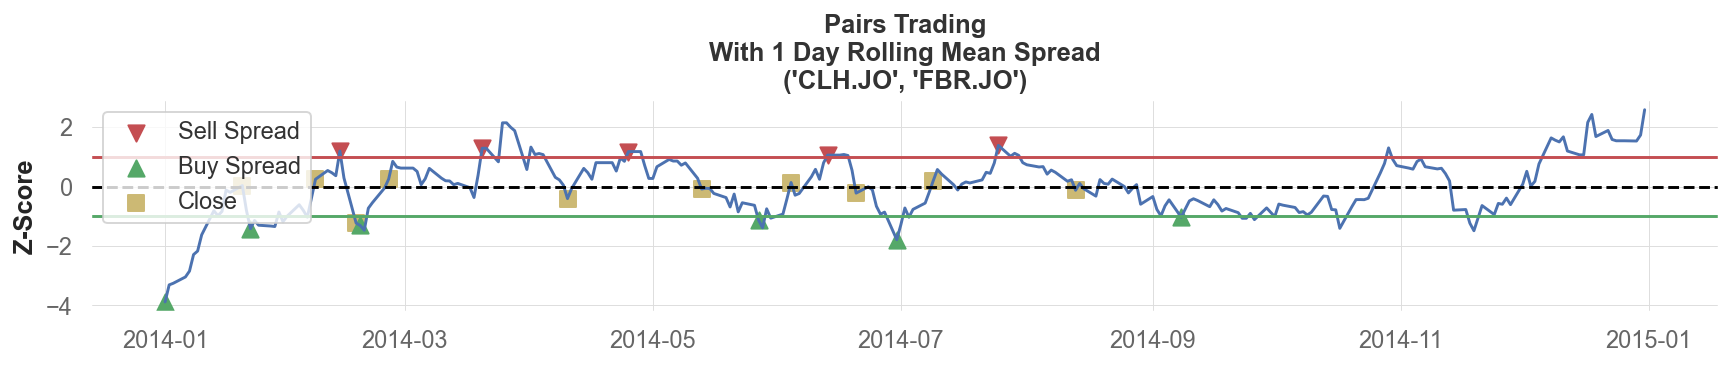

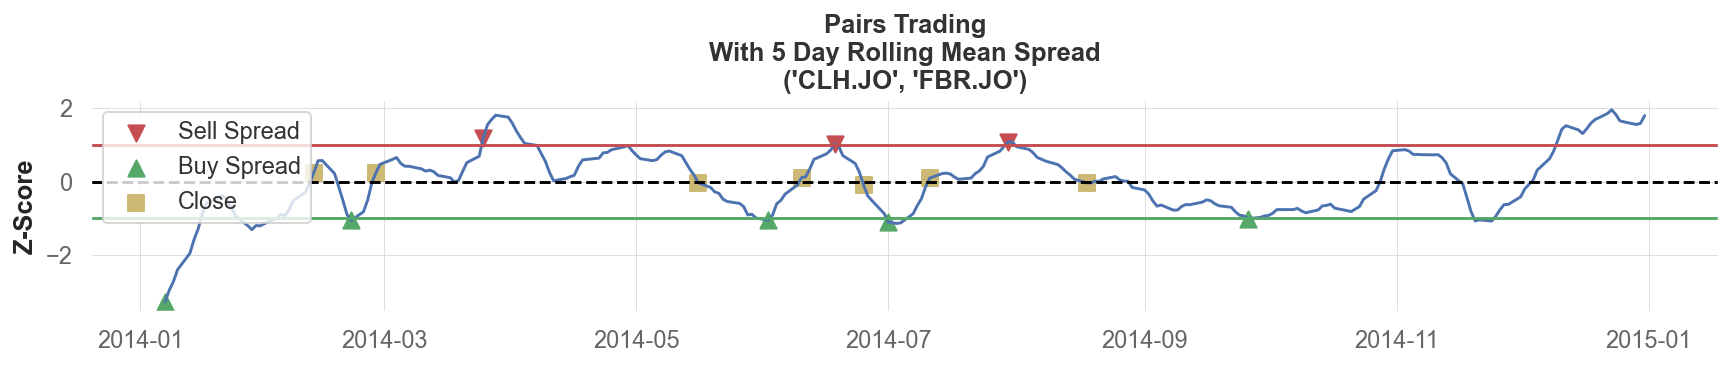

In [25]:
zscore_spread_plot(spread, coint_pairs[1], n=1)
zscore_spread_plot(spread, coint_pairs[1], n=5)

Looking at the two charts above, using a rolling mean spread allow us to avoid the swings and volatilty of the market, as a result limit false trade signals. We could use a rolling mean price as a open trade signal and close them with the day spread. 

In [26]:
def pairs_trade_plot(df, spread, pairs, title=None, n=5, trading_days=200):
    '''Returns Pair Trades Plot'''
    x, y = df[pairs[0]].rebase(), df[pairs[1]].rebase()
    z_score = spread[pairs].rolling(n).mean()
    in_market, position = False, None

    plt.figure(figsize=(15, 8))
    default_title = f'Pairs Trading\nwith {n} Day Rolling Mean Spread\n{pairs}'
    plt.title(default_title if title is None else title)
    plt.ylabel('Cummulative Returns')
    plt.plot(x, c='b'), plt.plot(y, c='gray')
    
    for i in range(trading_days):
    # Buying the Spread - Long Stock X and Short Stock Y
        if z_score.values[i] >= 1 and not in_market: 
            plt.scatter(z_score.index[i], x.values[i], marker='^', c='g', s=80)
            plt.scatter(z_score.index[i], y.values[i], marker='v', c='r', s=80)
            in_market, position = True, 'Buy'
        elif z_score.values[i] <= 0 and in_market and position is 'Buy':
            plt.scatter(z_score.index[i], x.values[i], marker='s', c='y', s=80)
            plt.scatter(z_score.index[i], y.values[i], marker='s', c='y', s=80)
            in_market = False
            
    # Selling the spread - Long Stock Y and Short Stock X
        elif z_score.values[i] <= -1 and not in_market: 
            plt.scatter(z_score.index[i], x.values[i], marker='v', c='r', s=80)
            plt.scatter(z_score.index[i], y.values[i], marker='^', c='g', s=80)
            in_market, position = True, 'Sell'  
        elif z_score.values[i] >= 0 and in_market and position is 'Sell':
            plt.scatter(z_score.index[i], x.values[i], marker='s', c='y', s=80)
            plt.scatter(z_score.index[i], y.values[i], marker='s', c='y', s=80)
            in_market = False
        plt.legend([pairs[0], pairs[1], 'Sell', 'Buy', 'Close'])

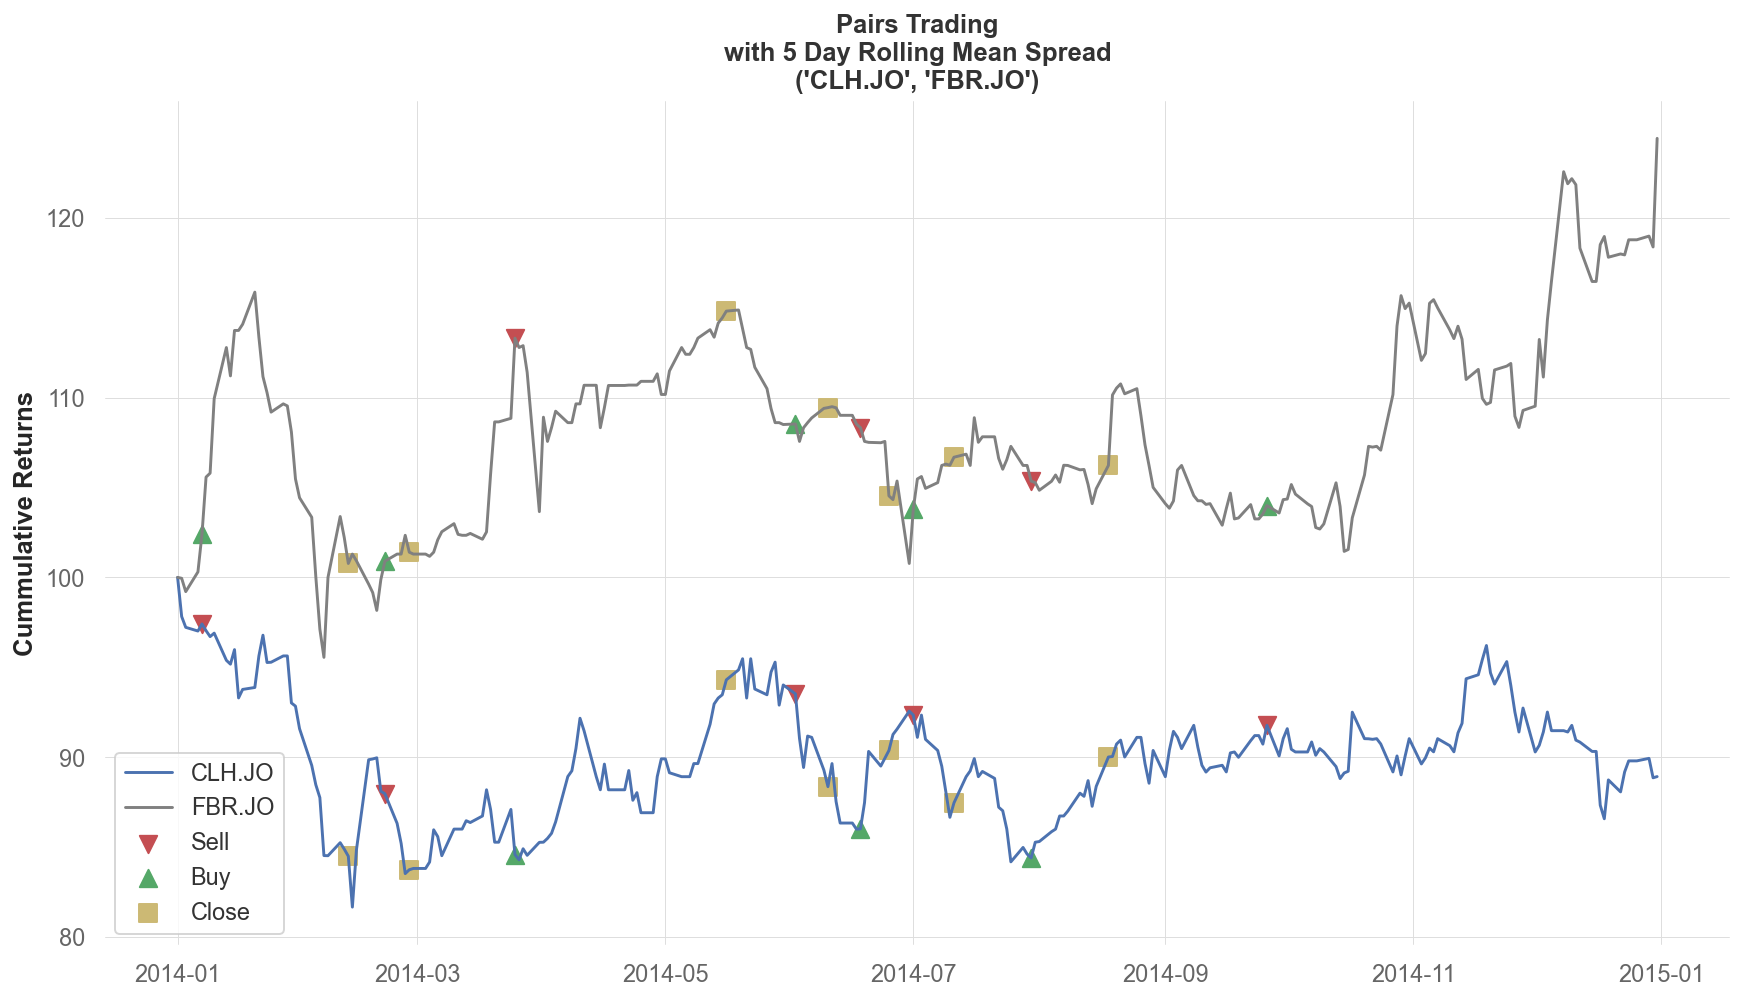

In [27]:
pairs_trade_plot(stocks, spread, coint_pairs[1])

## Algorithm

Our algorithm has to trade on some sort of live data. To simulate this we will use a `for loop` with a step size of 1 day. Meaning our algorithm will get updating daily stock price data per step size.

In [28]:
def backtest_algo(df, spread, pairs, n=5, trading_days=200):
    data = []
    columns = ['Pairs', 'Entry', 'Exit', 'Returns', 'Position', 'Holding Period']
    
    # Initialize the algorithm
    x, y = df[pairs[0]].rebase(), df[pairs[1]].rebase()
    z_score = spread[pairs].rolling(n).mean().dropna()
    in_market, close, position = False, False, None
    
    for i in range(trading_days):        
        # Buy Spread - Long Stock X and Short Stock Y
        if z_score.values[i] >= 1 and not in_market:
            entry = z_score.index[i]
            long_entry, short_entry = x.values[i], y.values[i]
            in_market, position = True, 'Buy'
        elif z_score.values[i] <= 0 and in_market and position is 'Buy':
            exit = z_score.index[i]
            long_exit, short_exit = x.values[i], y.values[i]
            returns = long_exit / long_entry - 2 + short_entry / short_exit
            in_market, close = False, True
        
        # Sell Spread - Long Stock Y and Short Stock X
        elif z_score.values[i] <= -1 and not in_market: 
            entry = z_score.index[i]
            long_entry, short_entry = y.values[i], x.values[i]
            in_market, position = True, 'Sell'  
        elif z_score.values[i] >= 0 and in_market and position is 'Sell':    
            exit = z_score.index[i]
            long_exit, short_exit = y.values[i], x.values[i]
            returns = long_exit / long_entry - 2 + short_entry / short_exit
            in_market, close = False, True
        
        # Store Results
        elif close:
            data.append((
                pairs, entry, exit, returns, position, exit - entry
            ))
            close = False
    return pd.DataFrame(data, columns=columns)

## Portfolio Construction

### Backtest

In [29]:
# backtest
bt = {}
for pair in coint_pairs:
    bt[pair] = backtest_algo(stocks, spread, pair)
backtest = pd.concat([bt[pairs] for pairs, vals in bt.items()])
backtest.sort_values('Exit', inplace=True) 
backtest

Pairs      Entry       Exit   Returns Position Holding Period
0   (FBR.JO, TRU.JO) 2014-01-07 2014-01-13  0.047485      Buy         6 days
0   (FBR.JO, LEW.JO) 2014-01-07 2014-01-14 -0.066077     Sell         7 days
0   (FBR.JO, SHP.JO) 2014-01-07 2014-01-15  0.089404      Buy         8 days
0   (TRU.JO, SHP.JO) 2014-01-08 2014-01-16  0.018911      Buy         8 days
0   (ITE.JO, NPK.JO) 2014-01-07 2014-01-31  0.062140      Buy        24 days
..               ...        ...        ...       ...      ...            ...
2   (TRU.JO, FBR.JO) 2014-08-19 2014-09-01 -0.005696      Buy        13 days
2   (CLH.JO, WHL.JO) 2014-07-15 2014-09-25  0.018883      Buy        72 days
5   (ITE.JO, NPK.JO) 2014-07-28 2014-09-25  0.029526      Buy        59 days
5   (FBR.JO, TRU.JO) 2014-09-08 2014-09-25  0.037202      Buy        17 days
2   (CLH.JO, PIK.JO) 2014-06-13 2014-09-26  0.056905      Buy       105 days

[119 rows x 6 columns]

In [30]:
backtest_returns = backtest[['Exit','Returns']].set_index('Exit') / len(coint_pairs)
backtest_returns.columns = ['Equally Weighted Porfolio']
performance_metrics(backtest_returns)

Expected Returns  Cummulative Returns  Volatility  \
Equally Weighted Porfolio          0.057303             0.121055    0.026212   

                           Sharpe Ratio  Sortino Ratio  Information Ratio  \
Equally Weighted Porfolio       9.24914        31.0673           -0.09167   

                           Skewness  Max Drawdown  CVaR at 95%  Pay-Off Ratio  
Equally Weighted Porfolio  0.927526     -0.005424    -0.002618       2.327379

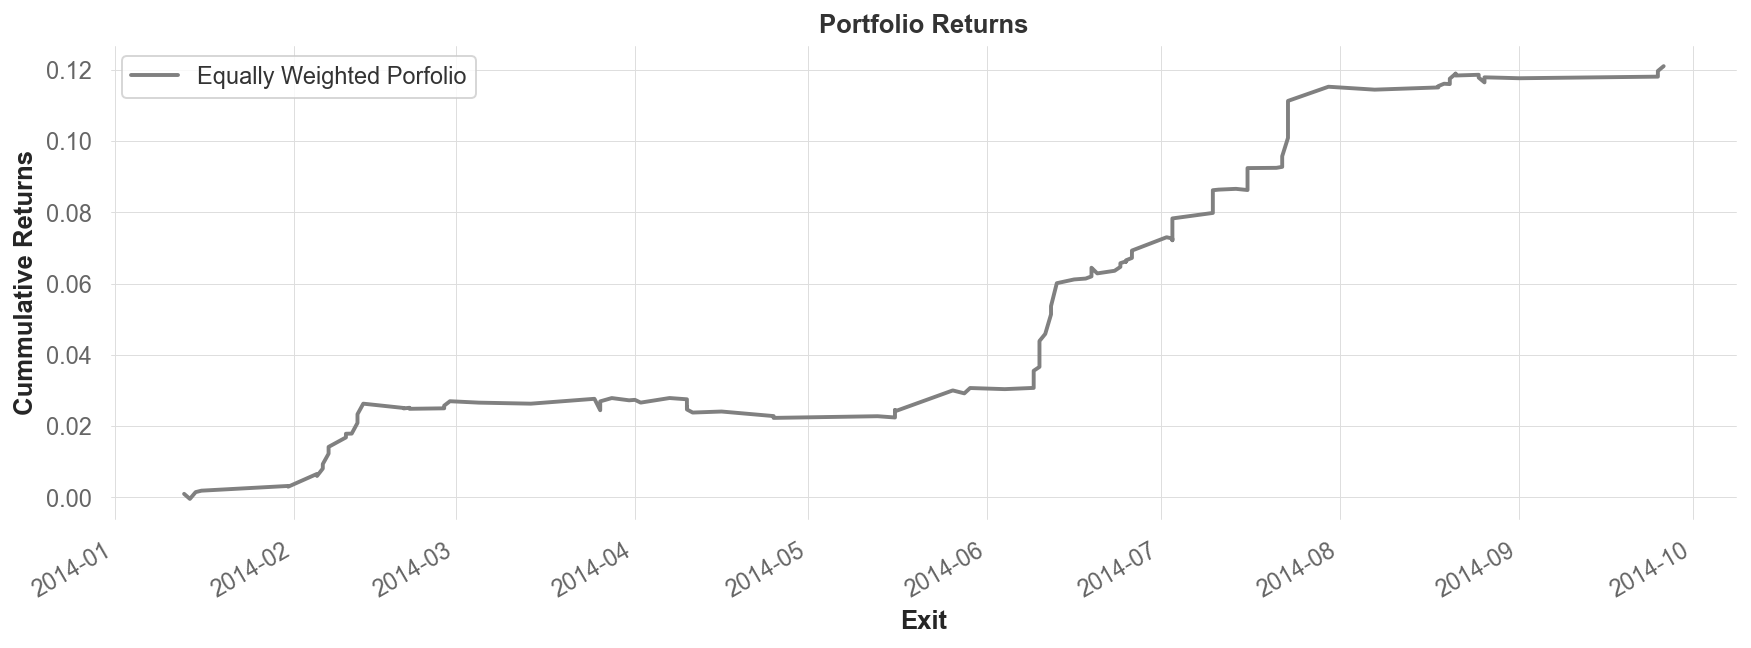

In [31]:
backtest_returns.compsum().plot(figsize=(15, 5), color='gray', lw=2)
plt.title('Portfolio Returns'), plt.ylabel('Cummulative Returns');

The graph above shows the portfolio performance for `coint_pairs` if we were to trade all of them. 

We would not trade all the pairs all our `coint_pairs` we will construct a porfolio by selecting the "best performing" pairs in our universe. 
The selection process will start with feature engineering whereby we group all the important features of the pairs and then we will transform them by reducing their dimension into a single numeric value then proceed with asset allocation.

### Feature Engineering

In [32]:
def feature_engineering(spread, backtest, coint_pairs):
    features = []
    columns = ['Pairs','Returns', 'Volatility', 'Sharpe Ratio','Max Drawdown',
               'Average Holding Period', 'No. of Trades', 'Buy Positions', 
               'Sell Positions', 'P-Value', 'Correlation']
    
    bt = backtest.copy()
    
    for pairs in coint_pairs:
        pair = bt[bt['Pairs'] == pairs]

        # performance metrics
        returns_ = pair['Returns']
        returns = returns_.comp()
        sharpe = returns_.sharpe()
        volatility = returns_.volatility()   
        max_dd = returns_.max_drawdown()

        # trades metrics
        holding_period = pair['Holding Period'].mean().days
        positions = np.where(pair['Position'] == 'Buy', 1, 0)
        buy_positions = positions.sum()
        sell_positions = len(positions) - buy_positions
        no_trades = len(pair)

        # stats metrics
        p_value = adfuller(spread[pairs])[1]
        corr = stocks[pairs[0]].to_returns().corr(stocks[pairs[1]].to_returns())

        features.append((
            pairs, returns, volatility, sharpe, max_dd, holding_period, 
            no_trades, buy_positions, sell_positions, p_value, corr
        ))
    
    return pd.DataFrame(features, columns=columns).set_index('Pairs')

In [33]:
features = feature_engineering(spread, backtest, coint_pairs)
features

Returns  Volatility  Sharpe Ratio  Max Drawdown  \
Pairs                                                                
(CLH.JO, CGR.JO)  0.332977    1.172069     11.005023     -0.039758   
(CLH.JO, FBR.JO)  0.277647    0.786885     11.721995     -0.016281   
(CLH.JO, GPL.JO) -0.007881    1.631074      0.393030     -0.148964   
(CLH.JO, ITE.JO)  0.179466    0.955348      7.740203     -0.033235   
(CLH.JO, LEW.JO)  0.068380         NaN           NaN      0.000000   
(CLH.JO, MPT.JO)  0.219060    0.185827    141.226224      0.000000   
(CLH.JO, MRP.JO)  0.210280         NaN           NaN      0.000000   
(CLH.JO, MSM.JO)  0.145602    1.081038      8.435443     -0.018172   
(CLH.JO, MTA.JO)  0.293252    1.049587     13.052731      0.000000   
(CLH.JO, NPK.JO)  0.022183    0.080584     22.981366      0.000000   
(CLH.JO, PIK.JO)  0.083410    0.618566     11.229005     -0.016648   
(CLH.JO, SHP.JO)  0.118190    0.337155     28.464274      0.000000   
(CLH.JO, SNH.JO)  0.165827    1.044620      7.919329     -0.039776   
(CLH.JO, SUI.JO)  0.246196         NaN           NaN      0.000000   
(CLH.JO, TFG.JO)  0.286662         NaN           NaN      0.000000   
(CLH.JO, TRU.JO)  0.027378    0.492122      2.969706     -0.040691   
(CLH.JO, TSG.JO)  0.066764    0.422381      6.633199     -0.021955   
(CLH.JO, WHL.JO)  0.237432    0.788232     23.776389      0.000000   
(FBR.JO, LEW.JO) -0.266435    0.893846    -20.647174     -0.214533   
(FBR.JO, MSM.JO)  0.032398    0.667073      6.234842      0.000000   
(FBR.JO, SHP.JO)  0.094688    0.871783      6.930519     -0.035229   
(FBR.JO, TRU.JO)  0.104188    0.493918      8.701196     -0.026938   
(GPL.JO, MTA.JO)  0.268935         NaN           NaN      0.000000   
(ITE.JO, MPT.JO)  0.078145         NaN           NaN      0.000000   
(ITE.JO, MRP.JO)  0.067116         NaN           NaN      0.000000   
(ITE.JO, MTA.JO)  0.168291         NaN           NaN      0.000000   
(ITE.JO, NPK.JO)  0.135135    0.780866      7.216196     -0.072405   
(ITE.JO, SUI.JO)  0.026762         NaN           NaN      0.000000   
(MPT.JO, ITE.JO)  0.011994         NaN           NaN      0.000000   
(MPT.JO, MTA.JO)  0.219841         NaN           NaN      0.000000   
(MPT.JO, NPK.JO)  0.128747         NaN           NaN      0.000000   
(MRP.JO, ITE.JO)  0.067116         NaN           NaN      0.000000   
(MTA.JO, ITE.JO)  0.164184         NaN           NaN      0.000000   
(MTA.JO, MPT.JO)  0.106036         NaN           NaN      0.000000   
(MTA.JO, MRP.JO)  0.162149         NaN           NaN      0.000000   
(MTA.JO, NPK.JO) -0.015792         NaN           NaN      0.000000   
(NPK.JO, ITE.JO)  0.094194         NaN           NaN      0.000000   
(NPK.JO, MPT.JO)  0.124812         NaN           NaN      0.000000   
(NPK.JO, MRP.JO)  0.266661         NaN           NaN      0.000000   
(NPK.JO, MTA.JO)  0.144743         NaN           NaN      0.000000   
(NPK.JO, SUI.JO)  0.219025         NaN           NaN      0.000000   
(SHP.JO, FBR.JO)  0.054526    0.477350     14.317734      0.000000   
(SNH.JO, CGR.JO) -0.057100    0.126137    -57.843701     -0.034572   
(SUI.JO, ITE.JO)  0.011642         NaN           NaN      0.000000   
(TRU.JO, FBR.JO) -0.003324    0.489777     -0.408041     -0.005696   
(TRU.JO, SHP.JO)  0.012793    0.269789      4.056148     -0.014328   
(WHL.JO, TFG.JO)  0.096361         NaN           NaN      0.000000   

                  Average Holding Period  No. of Trades  Buy Positions  \
Pairs                                                                    
(CLH.JO, CGR.JO)                      22              6              4   
(CLH.JO, FBR.JO)                      19              7              3   
(CLH.JO, GPL.JO)                      26              5              3   
(CLH.JO, ITE.JO)                      24              6              4   
(CLH.JO, LEW.JO)                     112              1              0   
(CLH.JO, MPT.JO)                      52              2              0

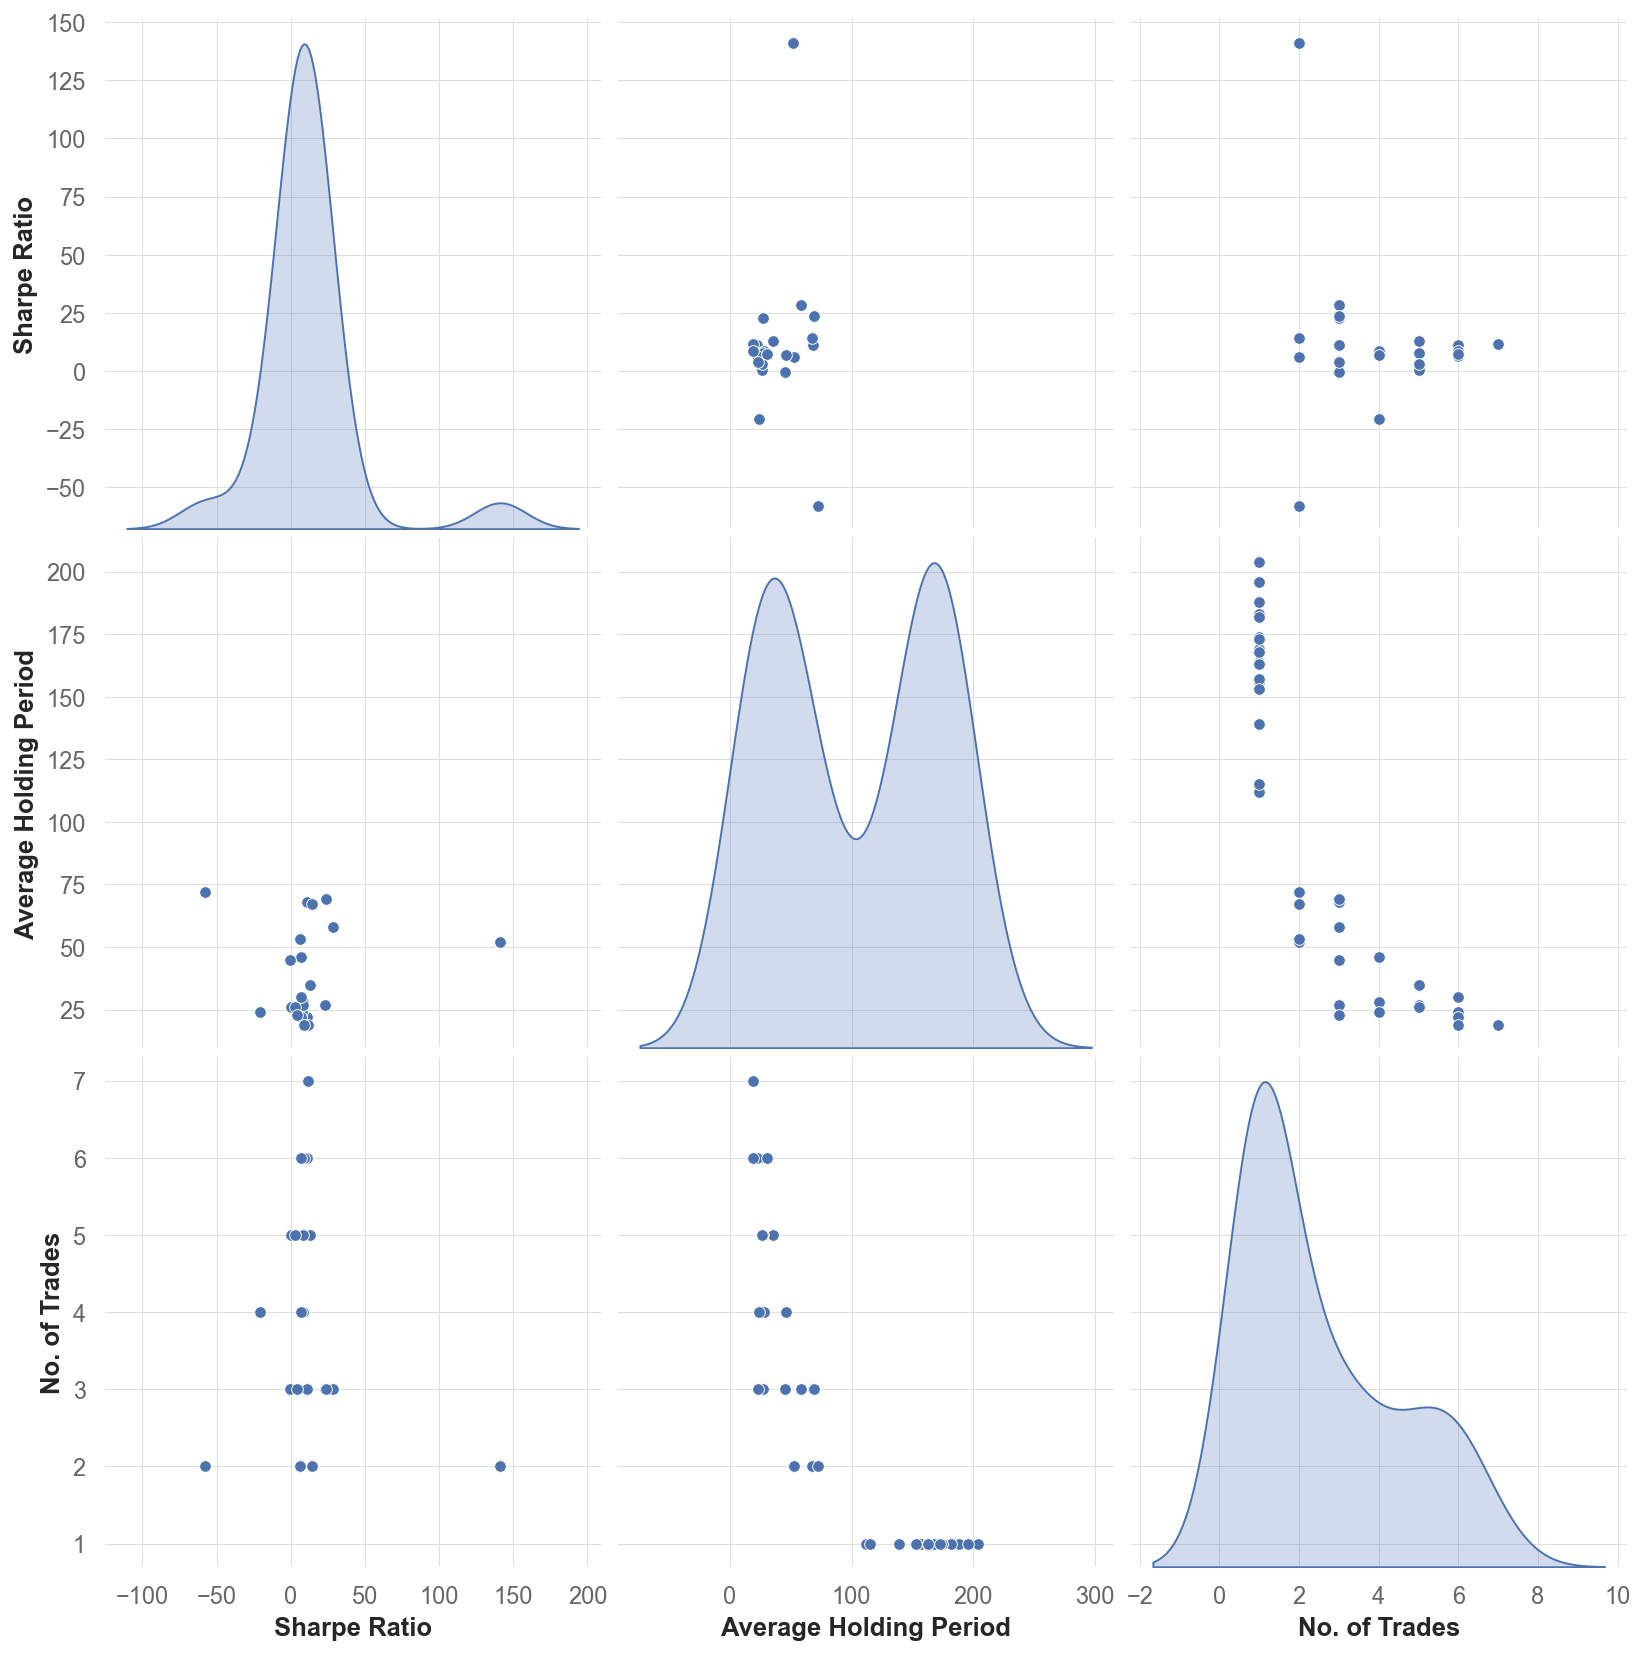

In [34]:
sns.pairplot(features, vars=['Sharpe Ratio', 'Average Holding Period', 
                             'No. of Trades'], size=4, diag_kind='kde');

In [35]:
features.dropna(inplace=True)
features = features[features['Returns'] > -1e-3] # drop negative returns

### Transformation and Factor Modelling

In this section we reduce the dimension of the features into a singlar value decomposition (factor) with the help of genetic programming. 

In [36]:
from gplearn.genetic import SymbolicTransformer
transformer = SymbolicTransformer(population_size=200,
                                  n_components=1,
                                  const_range=(0, 1.0),
                                  generations=20,
                                  tournament_size=20,
                                  parsimony_coefficient=5e-4,
                                  max_samples=.9,
                                  verbose=1,
                                  random_state=0)

In [37]:
# transformer
X = features.drop(['Returns','Sharpe Ratio'], axis=1)
y = features['Returns']
transformer.fit(X, y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.93         0.232813        9         0.658156                1      8.31s
   1    20.99         0.423893        1         0.780859                1      7.41s
   2     6.55         0.581878        7         0.843009                1      6.81s
   3     7.86         0.621257        7         0.867398                1      6.37s
   4    10.58         0.603574        5         0.865965                1      5.96s
   5    10.16         0.658842       17         0.871013                1      4.91s
   6    13.33         0.652624        9         0.905608                1      4.60s
   7    15.32         0.671841       29          0.85099                1      4.88s
   8    22.44         0.690608       25         0.916225                1  

SymbolicTransformer(const_range=(0, 1.0), max_samples=0.9, n_components=1,
                    parsimony_coefficient=0.0005, population_size=200,
                    random_state=0, verbose=1)

In [38]:
features['Factor'] = transformer.transform(X)
factors = features.copy().sort_values('Factor', ascending=False)

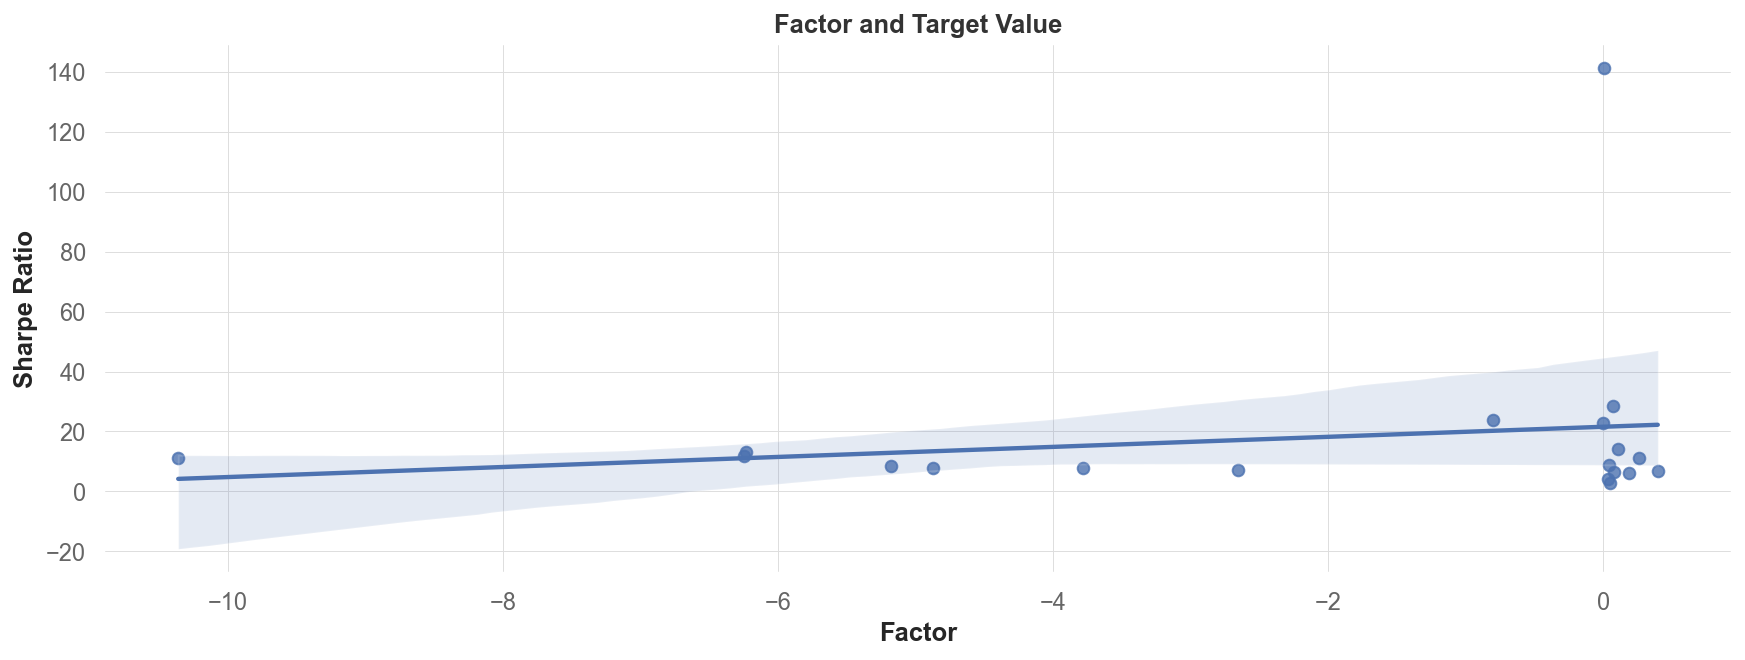

In [39]:
plt.figure(figsize=(15, 5))
plt.title('Factor and Target Value')
sns.regplot(factors['Factor'], factors['Sharpe Ratio']);

Ideally we would like to have a positive linear relationship between our transformation value and the target value, from the scatter plot above the relationship seems to be negative. Let's do some more selection and filtering and see if it does not improve.

### Asset allocation

**Selection and Filtering**

In [40]:
factors = factors[factors['P-Value'] <= .05] # stationary spread
factors = factors[factors['Average Holding Period'] <= 30]
factors = factors[factors['No. of Trades'] >= 5]

# standardize factor
rebalance = lambda x: abs(x) / np.sum(abs(x))
factors['Factor'] = rebalance(factors['Factor'])

In [41]:
factors

Returns  Volatility  Sharpe Ratio  Max Drawdown  \
Pairs                                                                
(CLH.JO, TSG.JO)  0.066764    0.422381      6.633199     -0.021955   
(CLH.JO, TRU.JO)  0.027378    0.492122      2.969706     -0.040691   
(FBR.JO, TRU.JO)  0.104188    0.493918      8.701196     -0.026938   
(ITE.JO, NPK.JO)  0.135135    0.780866      7.216196     -0.072405   
(CLH.JO, ITE.JO)  0.179466    0.955348      7.740203     -0.033235   
(CLH.JO, SNH.JO)  0.165827    1.044620      7.919329     -0.039776   
(CLH.JO, FBR.JO)  0.277647    0.786885     11.721995     -0.016281   
(CLH.JO, CGR.JO)  0.332977    1.172069     11.005023     -0.039758   

                  Average Holding Period  No. of Trades  Buy Positions  \
Pairs                                                                    
(CLH.JO, TSG.JO)                      22              6              4   
(CLH.JO, TRU.JO)                      26              5              3   
(FBR.JO, TRU.JO)                      19              6              4   
(ITE.JO, NPK.JO)                      30              6              2   
(CLH.JO, ITE.JO)                      24              6              4   
(CLH.JO, SNH.JO)                      27              5              3   
(CLH.JO, FBR.JO)                      19              7              3   
(CLH.JO, CGR.JO)                      22              6              4   

                  Sell Positions   P-Value  Correlation    Factor  
Pairs                                                              
(CLH.JO, TSG.JO)               2  0.001429     0.026750  0.002936  
(CLH.JO, TRU.JO)               2  0.001103     0.031890  0.001798  
(FBR.JO, TRU.JO)               2  0.004730     0.077075  0.001539  
(ITE.JO, NPK.JO)               4  0.002117    -0.061995  0.094575  
(CLH.JO, ITE.JO)               2  0.000892     0.103948  0.134700  
(CLH.JO, SNH.JO)               2  0.002029     0.009111  0.173485  
(CLH.JO, FBR.JO)               4  0.001892    -0.045830  0.222267  
(CLH.JO, CGR.JO)               2  0.008936     0.007602  0.368700

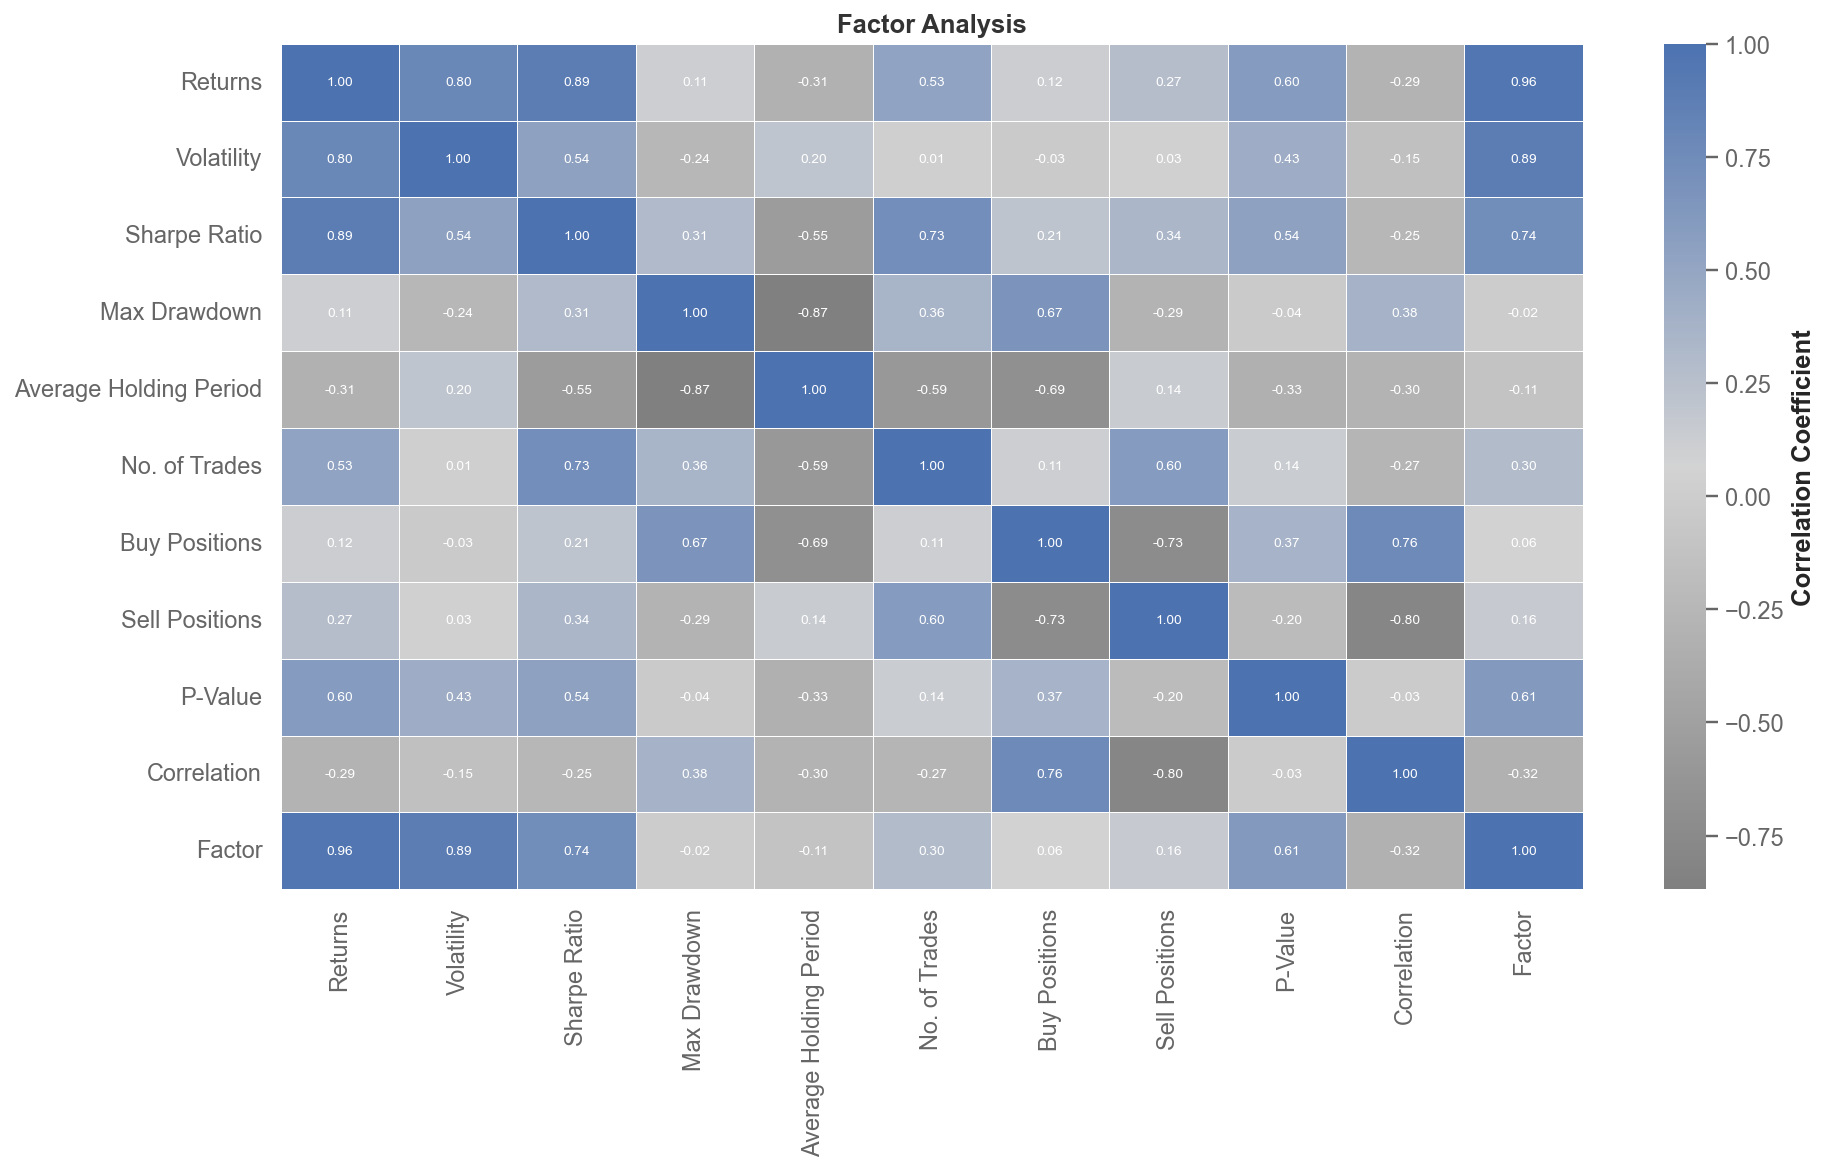

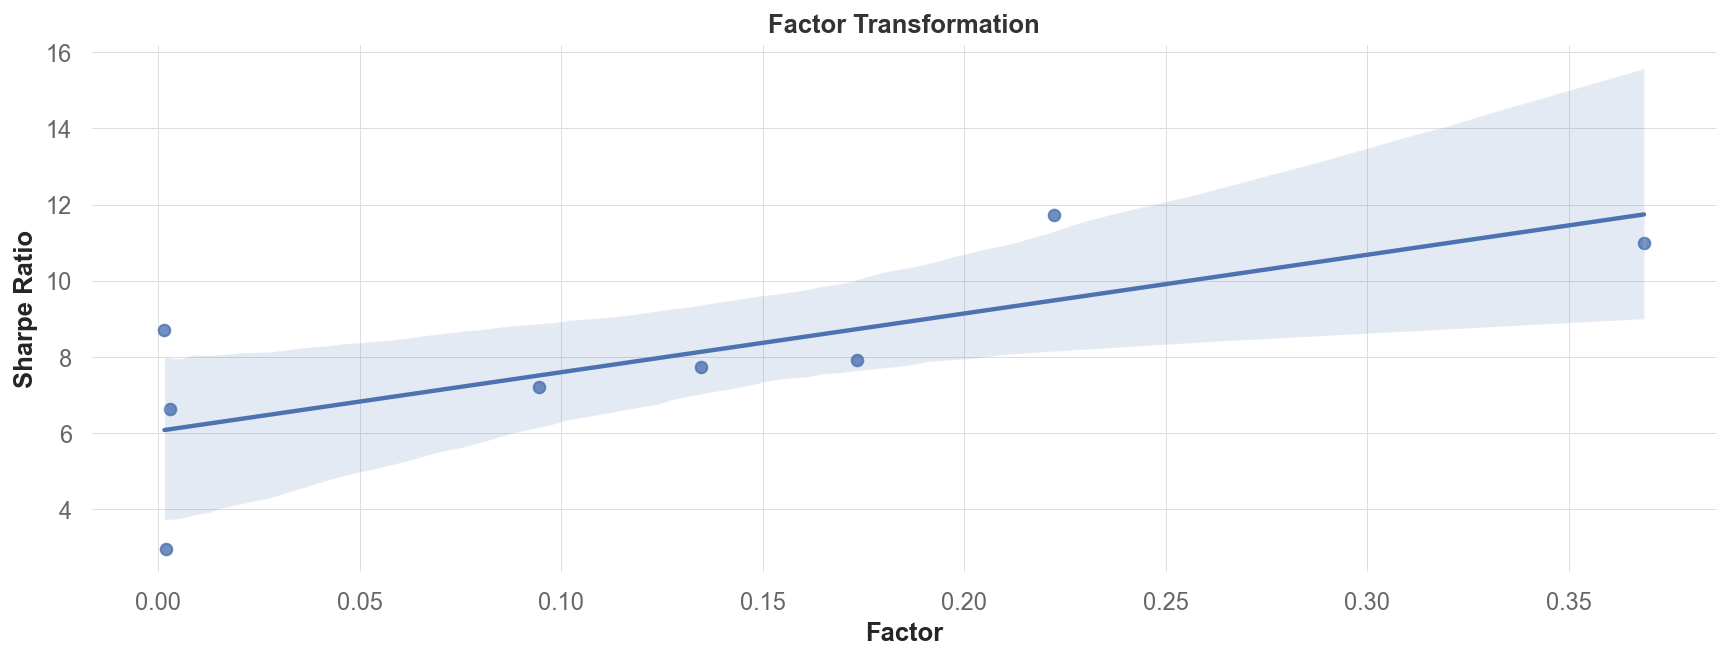

In [42]:
# heatmap
plt.figure(figsize=(15, 8)), plt.title('Factor Analysis')
sns.heatmap(factors.corr(), cmap=colormap, annot=True, fmt='.2f', 
            linewidth=0.5, annot_kws={'fontsize':7, 'color':'white'},
           cbar_kws={'label':'Correlation Coefficient'})
# reg plot
plt.figure(figsize=(15, 5))
plt.title('Factor Transformation')
sns.regplot(factors['Factor'], factors['Sharpe Ratio']);

As shown on the scatter plot above our `Factor` has a somewhat positive linear relationship with the `Sharpe Ratio`, in turn we will use these factor values as porfolio allocations for our portfolio weights.

**Portfolio Weights**

In [43]:
asset_weights = pd.DataFrame(factors['Factor'])
asset_weights.columns = ['Weights']
asset_weights.round(2)

Weights
Pairs                    
(CLH.JO, TSG.JO)     0.00
(CLH.JO, TRU.JO)     0.00
(FBR.JO, TRU.JO)     0.00
(ITE.JO, NPK.JO)     0.09
(CLH.JO, ITE.JO)     0.13
(CLH.JO, SNH.JO)     0.17
(CLH.JO, FBR.JO)     0.22
(CLH.JO, CGR.JO)     0.37

### Portfolio Analysis

In [44]:
# portfolio returns
List = []
for pair in asset_weights.index:
    allocation = asset_weights.loc[{pair}].values
    pair_ = backtest[backtest['Pairs'] == pair]
    pair_['Allocation'] = np.repeat(allocation, len(pair_))
    List.append(pair_)
backtest = pd.concat(List).sort_values('Exit')
backtest['Portfolio Returns'] = backtest.eval('Allocation * Returns')

In [45]:
backtest

Pairs      Entry       Exit   Returns Position Holding Period  \
0  (FBR.JO, TRU.JO) 2014-01-07 2014-01-13  0.047485      Buy         6 days   
0  (ITE.JO, NPK.JO) 2014-01-07 2014-01-31  0.062140      Buy        24 days   
1  (FBR.JO, TRU.JO) 2014-01-20 2014-02-05 -0.026938     Sell        16 days   
0  (CLH.JO, TSG.JO) 2014-01-07 2014-02-06  0.058822     Sell        30 days   
0  (CLH.JO, ITE.JO) 2014-01-07 2014-02-06  0.097196     Sell        30 days   
0  (CLH.JO, CGR.JO) 2014-01-07 2014-02-07  0.088229     Sell        31 days   
0  (CLH.JO, TRU.JO) 2014-01-07 2014-02-10  0.048160     Sell        34 days   
0  (CLH.JO, SNH.JO) 2014-01-07 2014-02-10  0.123052     Sell        34 days   
0  (CLH.JO, FBR.JO) 2014-01-07 2014-02-12  0.138565     Sell        36 days   
1  (CLH.JO, CGR.JO) 2014-02-13 2014-02-20 -0.005610      Buy         7 days   
1  (CLH.JO, ITE.JO) 2014-02-11 2014-02-21 -0.013500      Buy        10 days   
1  (CLH.JO, TSG.JO) 2014-02-11 2014-02-21  0.008496      Buy        10 days   
1  (CLH.JO, TRU.JO) 2014-02-20 2014-02-27  0.006243     Sell         7 days   
1  (CLH.JO, FBR.JO) 2014-02-21 2014-02-27  0.034286     Sell         6 days   
1  (ITE.JO, NPK.JO) 2014-02-05 2014-02-28  0.057014     Sell        23 days   
2  (ITE.JO, NPK.JO) 2014-03-18 2014-04-07  0.058740     Sell        20 days   
2  (CLH.JO, ITE.JO) 2014-02-27 2014-04-10 -0.016326      Buy        42 days   
2  (CLH.JO, TSG.JO) 2014-02-27 2014-04-10  0.002841      Buy        42 days   
2  (CLH.JO, CGR.JO) 2014-02-28 2014-04-10 -0.034340      Buy        41 days   
1  (CLH.JO, SNH.JO) 2014-02-28 2014-04-11 -0.039776      Buy        42 days   
3  (ITE.JO, NPK.JO) 2014-04-21 2014-04-25 -0.058773     Sell         4 days   
2  (CLH.JO, FBR.JO) 2014-03-25 2014-05-16 -0.016281      Buy        52 days   
2  (CLH.JO, TRU.JO) 2014-03-27 2014-05-28 -0.037490      Buy        62 days   
3  (CLH.JO, TSG.JO) 2014-05-20 2014-06-09  0.015884     Sell        20 days   
3  (CLH.JO, FBR.JO) 2014-06-02 2014-06-10  0.049594     Sell         8 days   
2  (CLH.JO, SNH.JO) 2014-05-19 2014-06-10  0.038240     Sell        22 days   
3  (CLH.JO, CGR.JO) 2014-05-16 2014-06-10  0.172728     Sell        25 days   
3  (CLH.JO, ITE.JO) 2014-05-16 2014-06-12  0.104154     Sell        27 days   
2  (FBR.JO, TRU.JO) 2014-04-30 2014-06-16  0.046754      Buy        47 days   
3  (CLH.JO, TRU.JO) 2014-06-18 2014-06-25 -0.003326      Buy         7 days   
4  (CLH.JO, FBR.JO) 2014-06-18 2014-06-25  0.016712      Buy         7 days   
4  (CLH.JO, ITE.JO) 2014-06-18 2014-06-26  0.037772      Buy         8 days   
4  (CLH.JO, TSG.JO) 2014-06-18 2014-06-26  0.002620      Buy         8 days   
4  (CLH.JO, CGR.JO) 2014-06-18 2014-06-26  0.028231      Buy         8 days   
3  (CLH.JO, SNH.JO) 2014-06-18 2014-07-03 -0.021202      Buy        15 days   
5  (CLH.JO, FBR.JO) 2014-07-01 2014-07-11  0.007045     Sell        10 days   
4  (ITE.JO, NPK.JO) 2014-05-26 2014-07-16 -0.014483     Sell        51 days   
3  (FBR.JO, TRU.JO) 2014-07-02 2014-07-21  0.002953      Buy        19 days   
4  (CLH.JO, TRU.JO) 2014-07-29 2014-08-18  0.015409      Buy        20 days   
6  (CLH.JO, FBR.JO) 2014-07-30 2014-08-18  0.026297      Buy        19 days   
4  (CLH.JO, SNH.JO) 2014-07-28 2014-08-20  0.063826      Buy        23 days   
5  (CLH.JO, TSG.JO) 2014-07-25 2014-08-21 -0.021955      Buy        27 days   
5  (CLH.JO, CGR.JO) 2014-07-28 2014-08-21  0.057872      Buy        24 days   
5  (CLH.JO, ITE.JO) 2014-07-28 2014-08-25 -0.033235      Buy        28 days   
4  (FBR.JO, TRU.JO) 2014-08-20 2014-08-29 -0.005130     Sell         9 days   
5  (ITE.JO, NPK.JO) 2014-07-28 2014-09-25  0.029526      Buy        59 days   
5  (FBR.JO, TRU.JO) 2014-09-08 2014-09-25  0.037202      Buy        17 days   

   Allocation  Portfolio Returns  
0    0.001539           0.000073  
0    0.094575           0.005877  
1    0.001539          -0.000041  
0    0.002936           0.000173  
0    0.134700           0.013092  
0    0.3687

For interest sake, let's visualize how each pair performed...

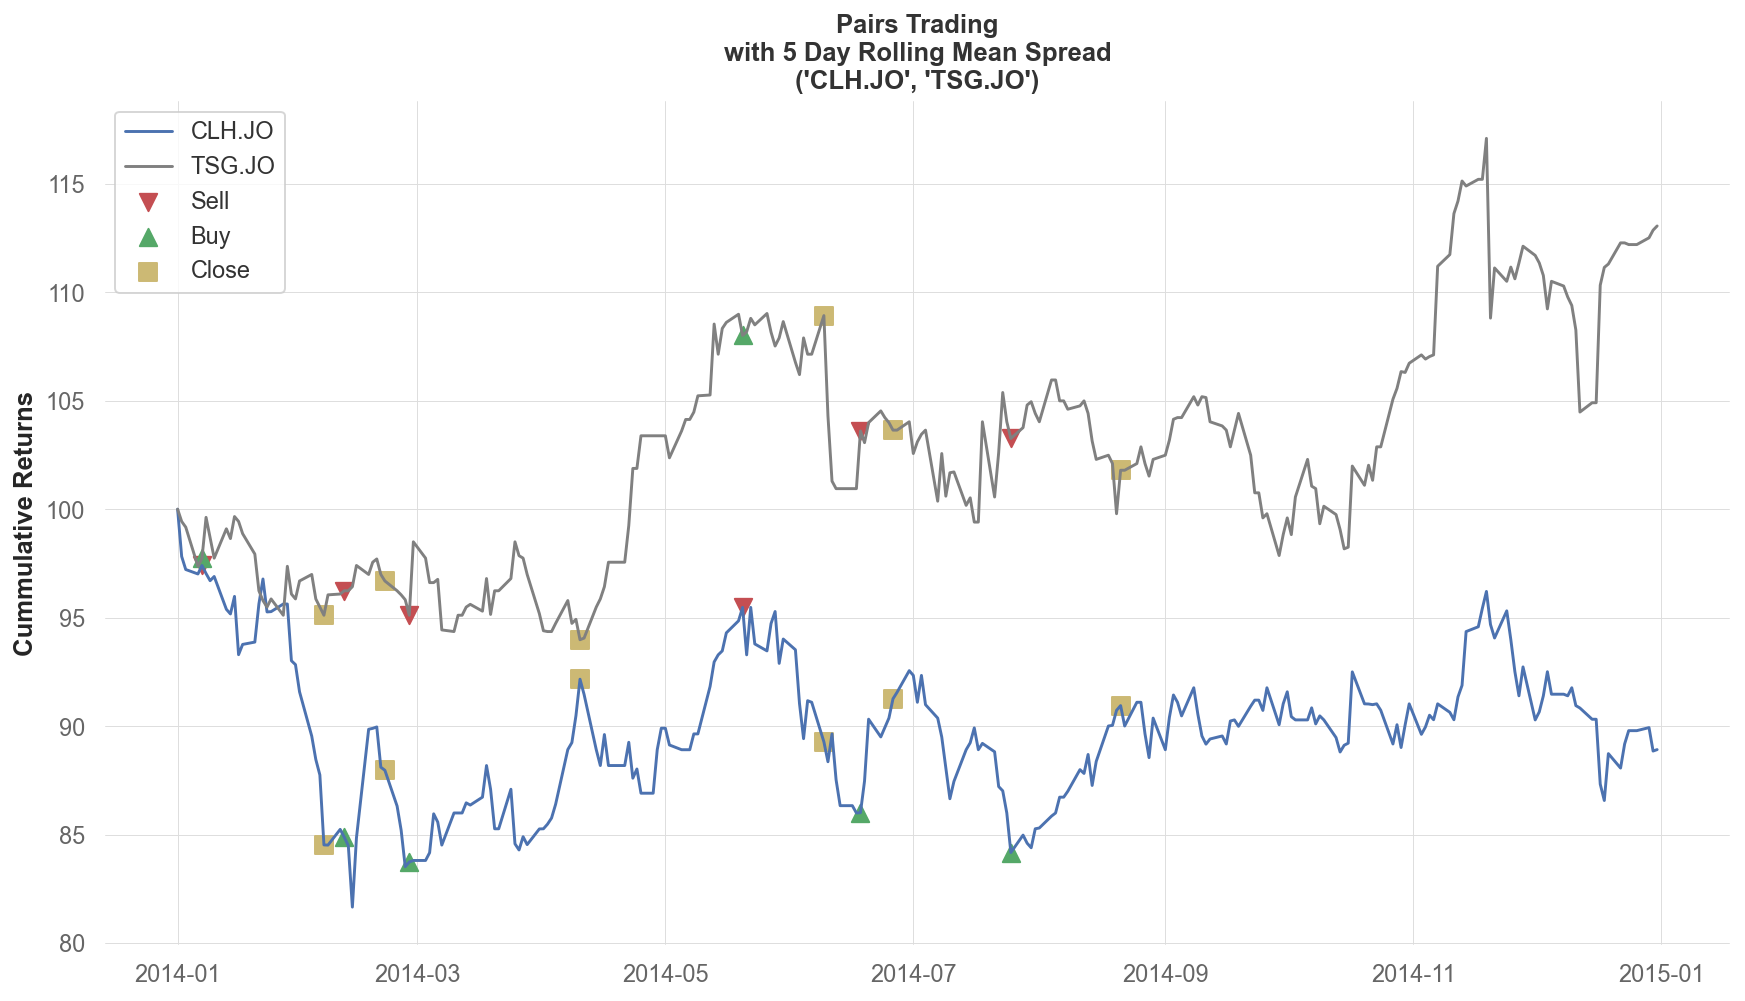

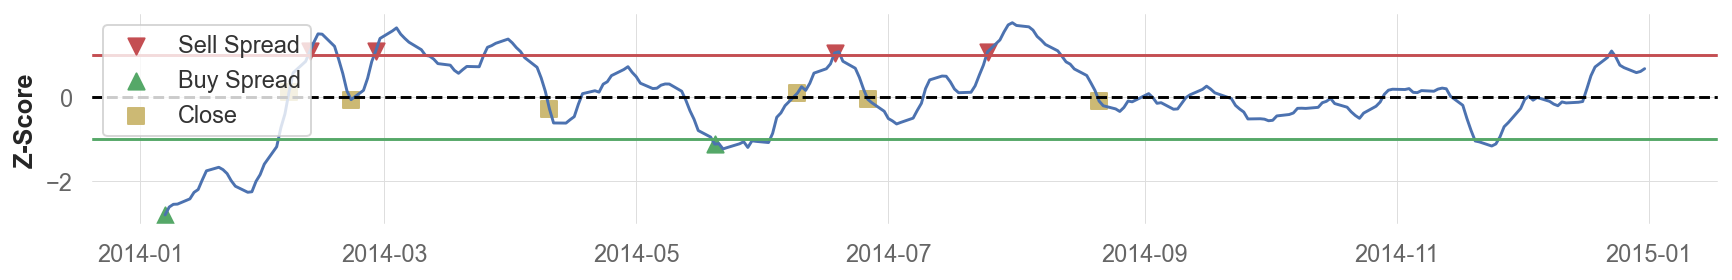

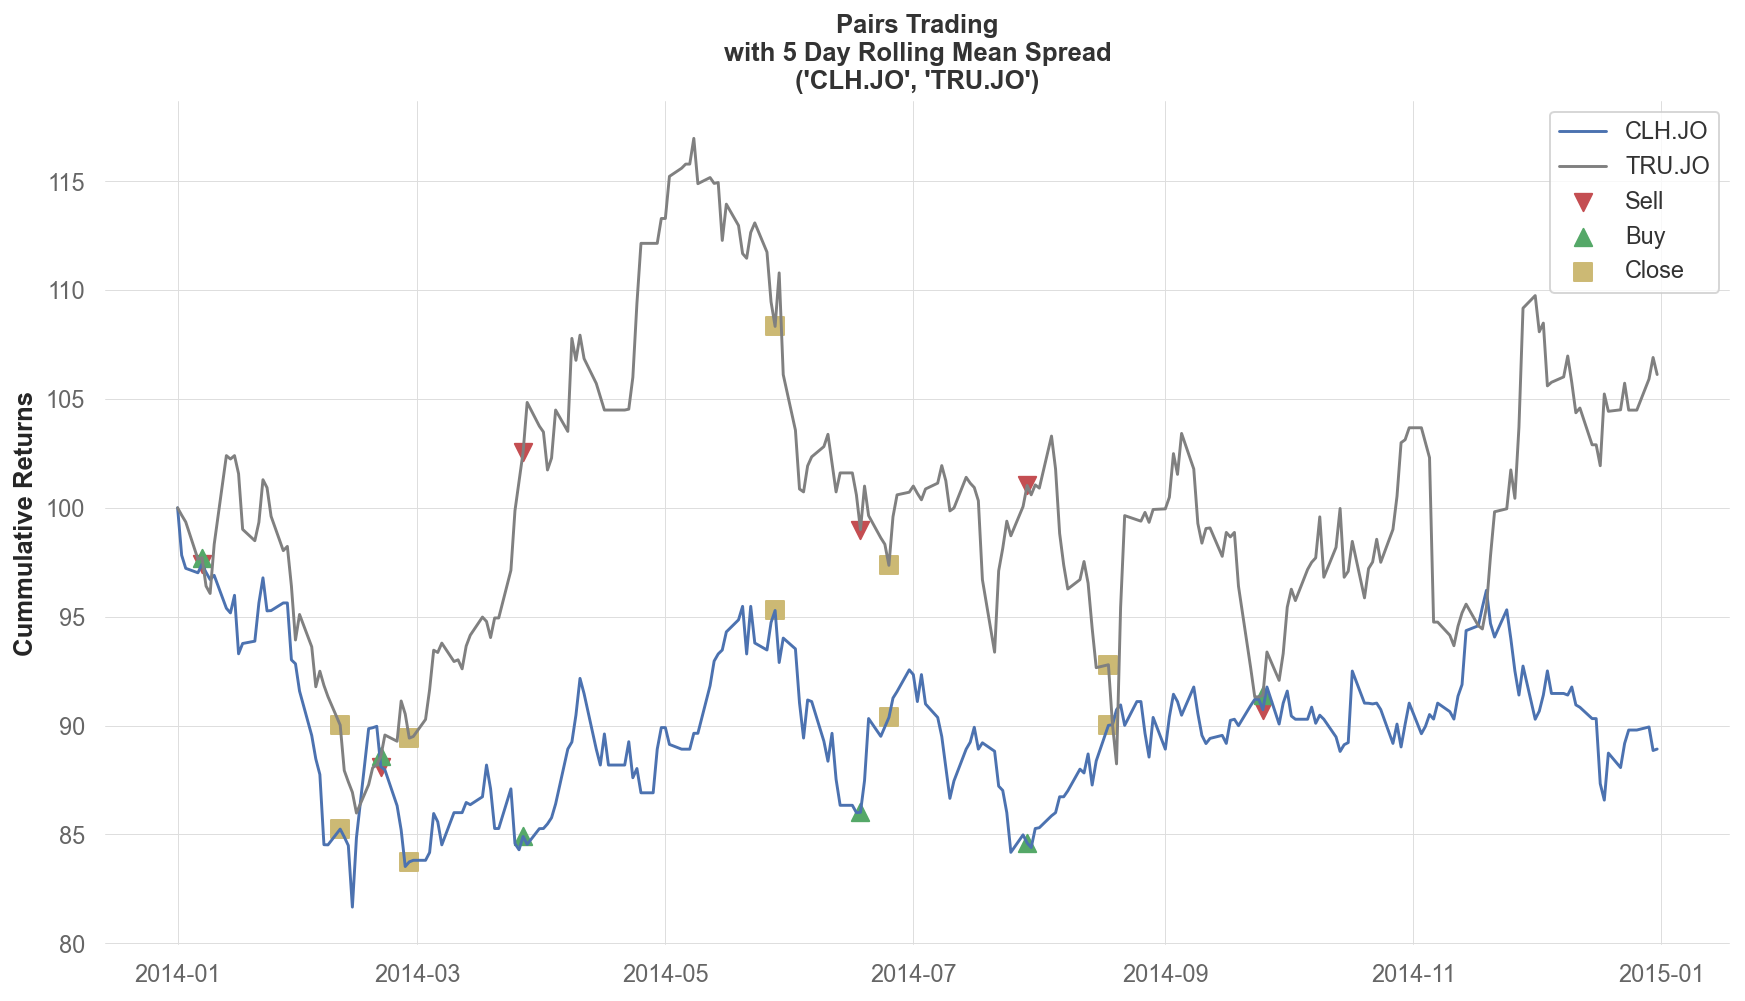

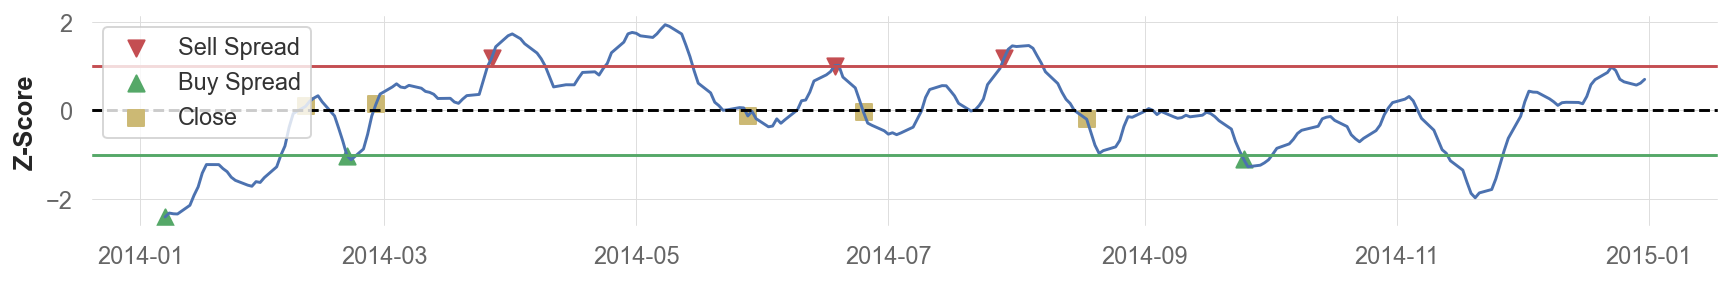

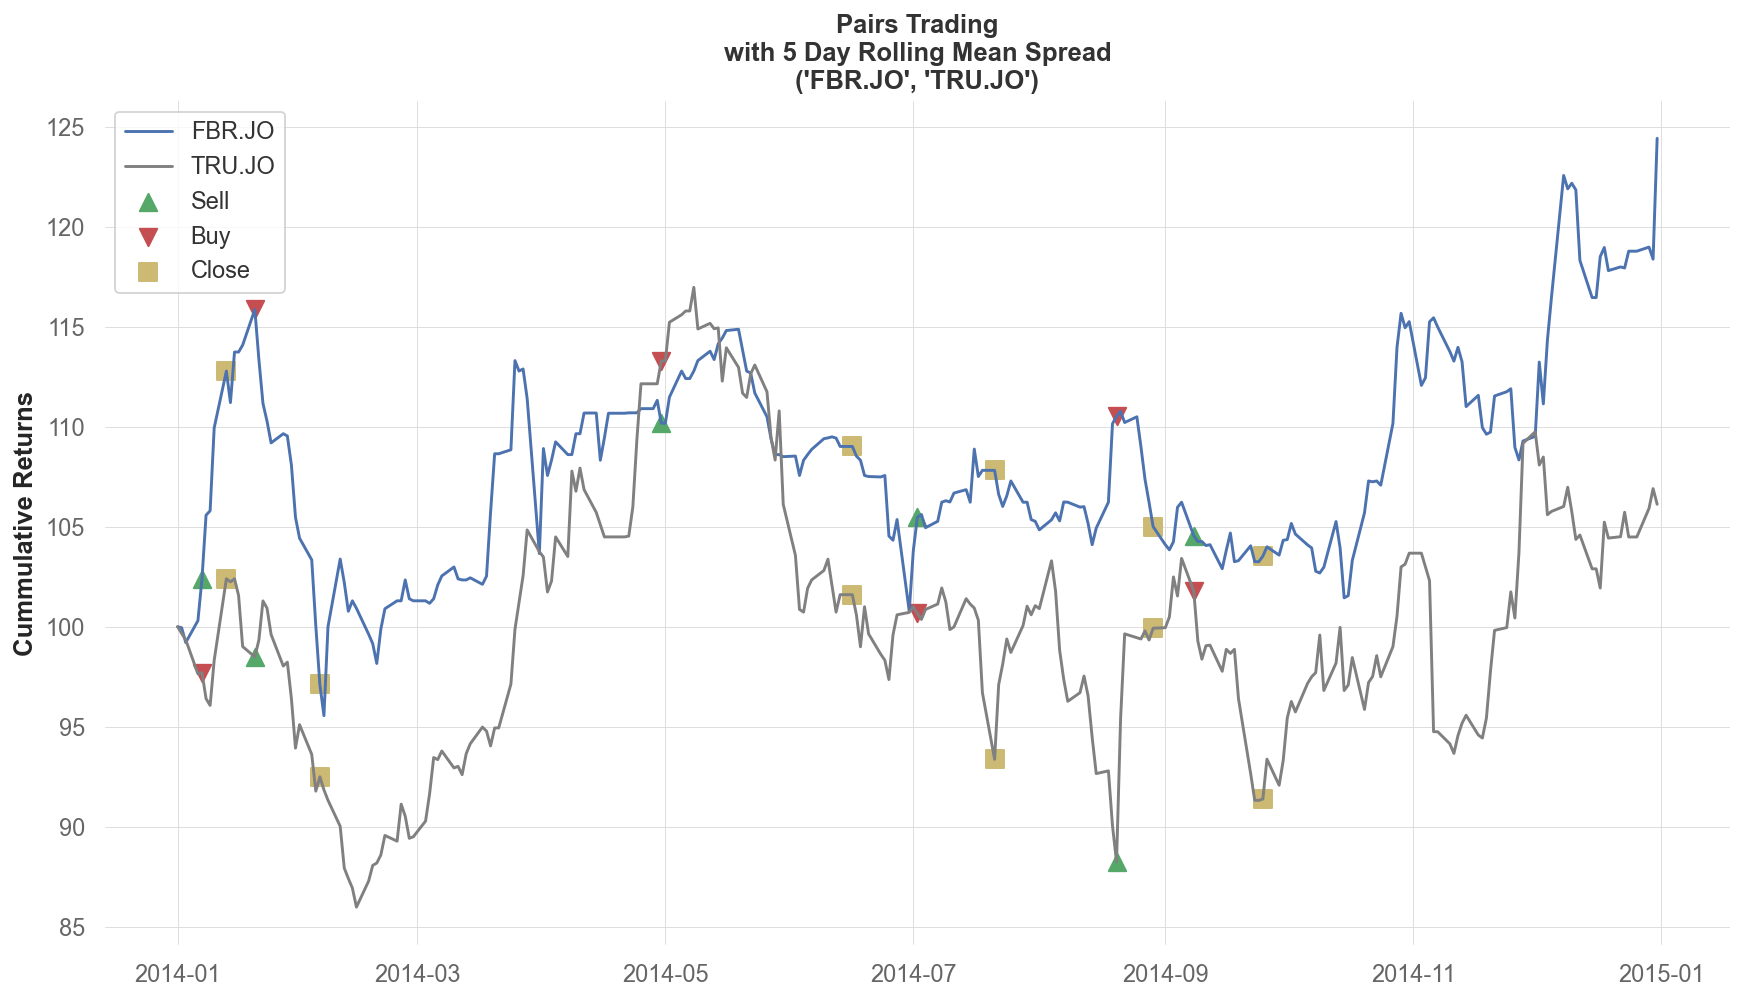

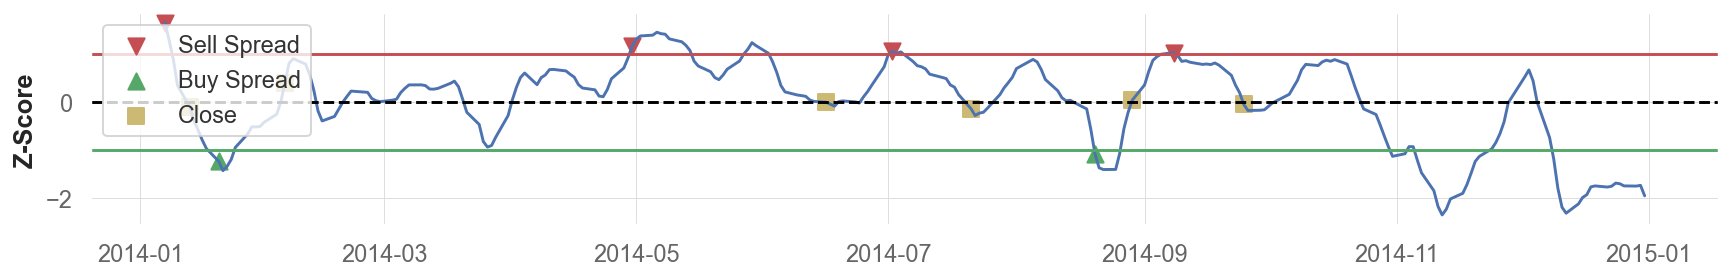

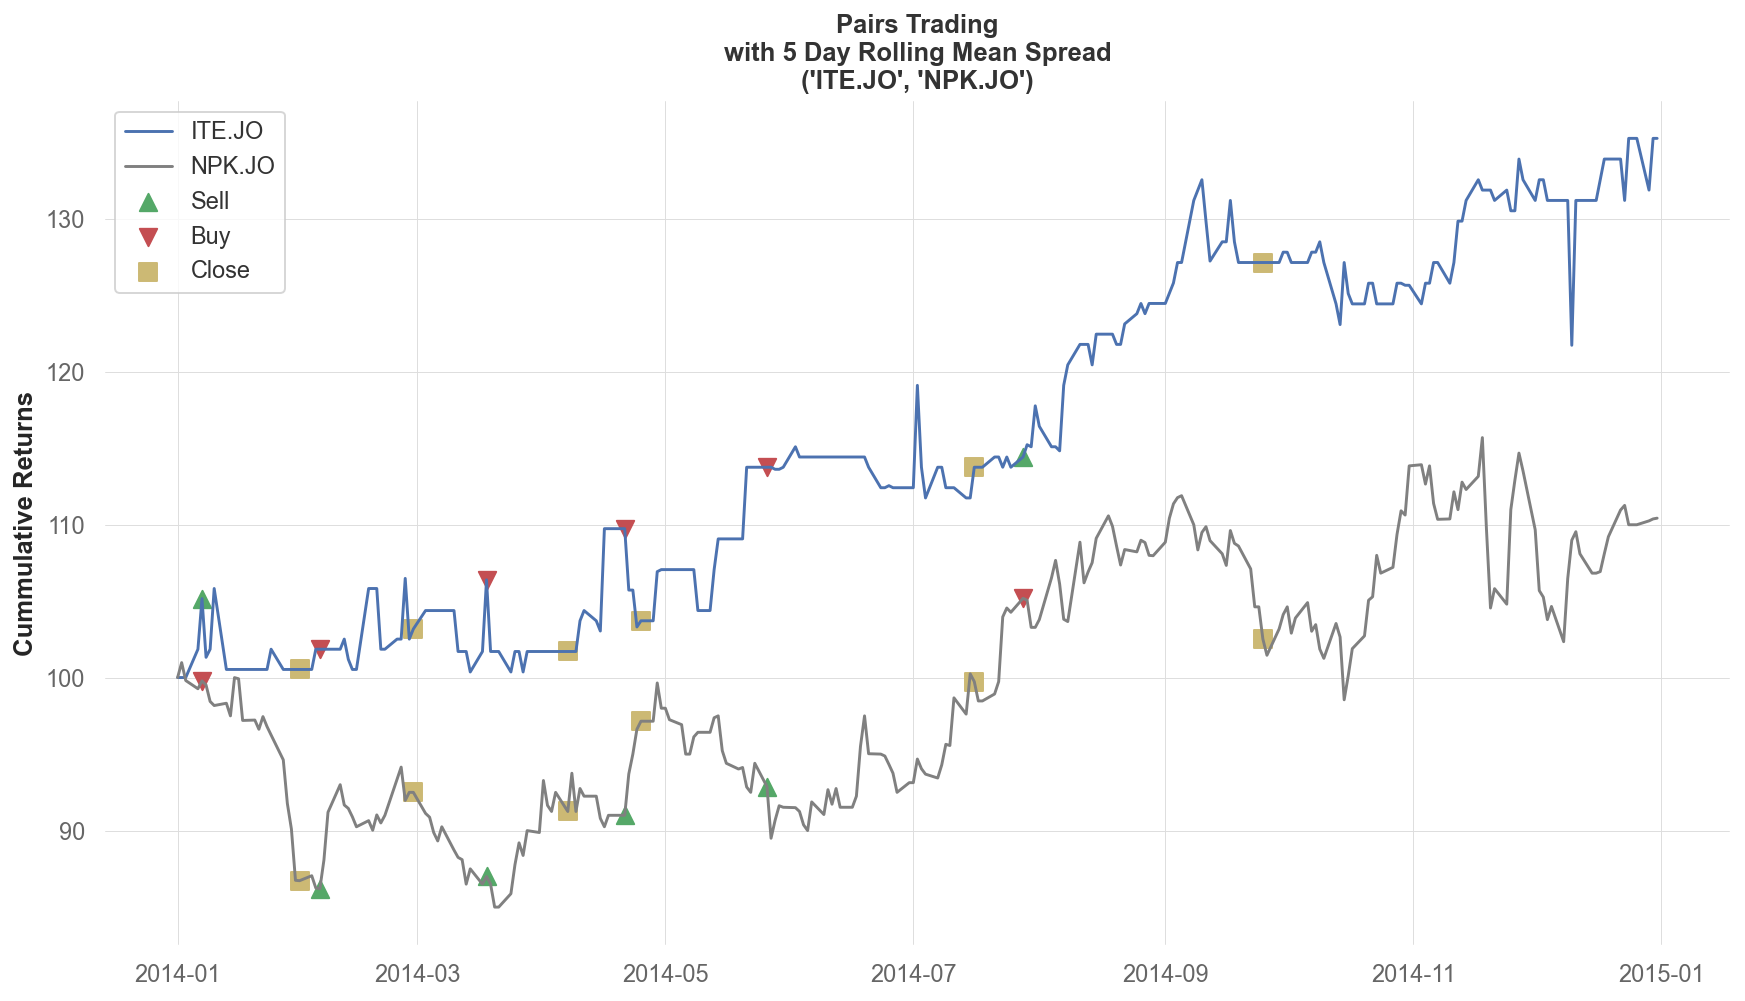

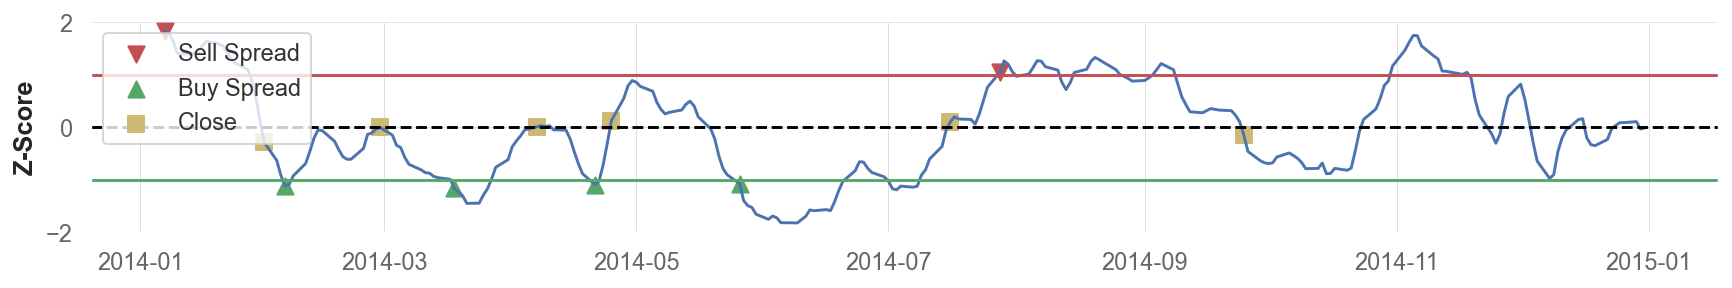

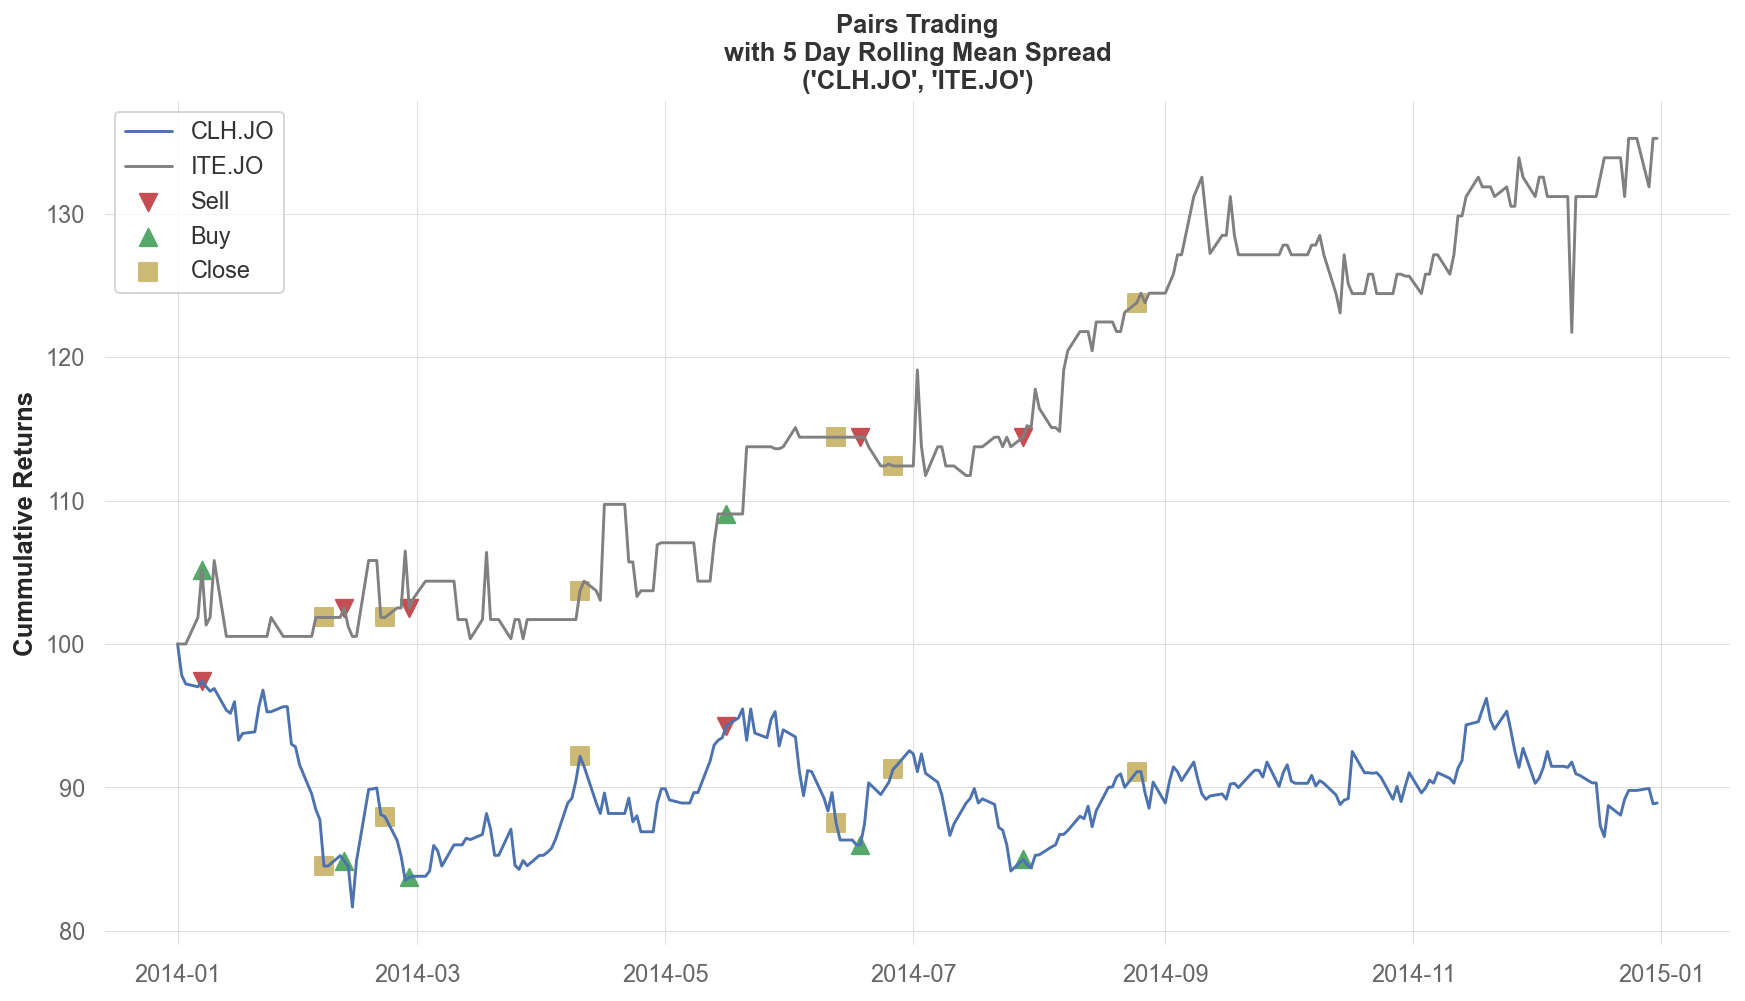

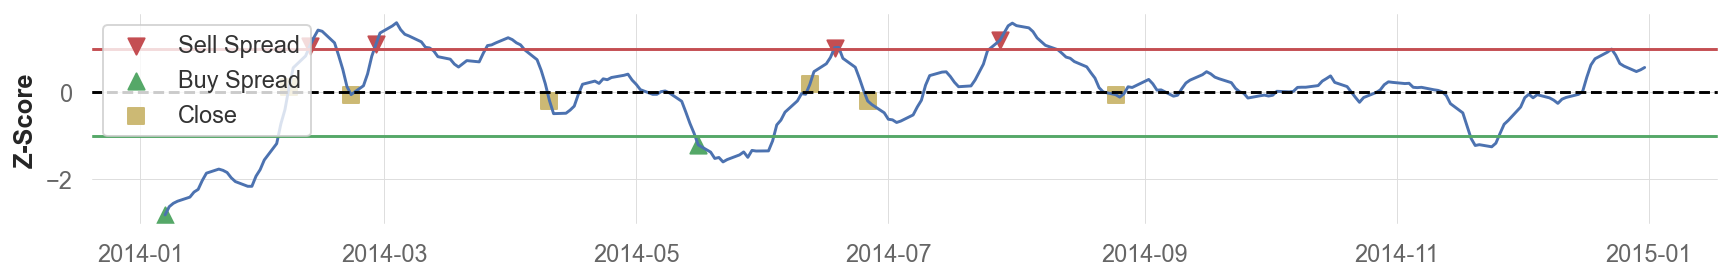

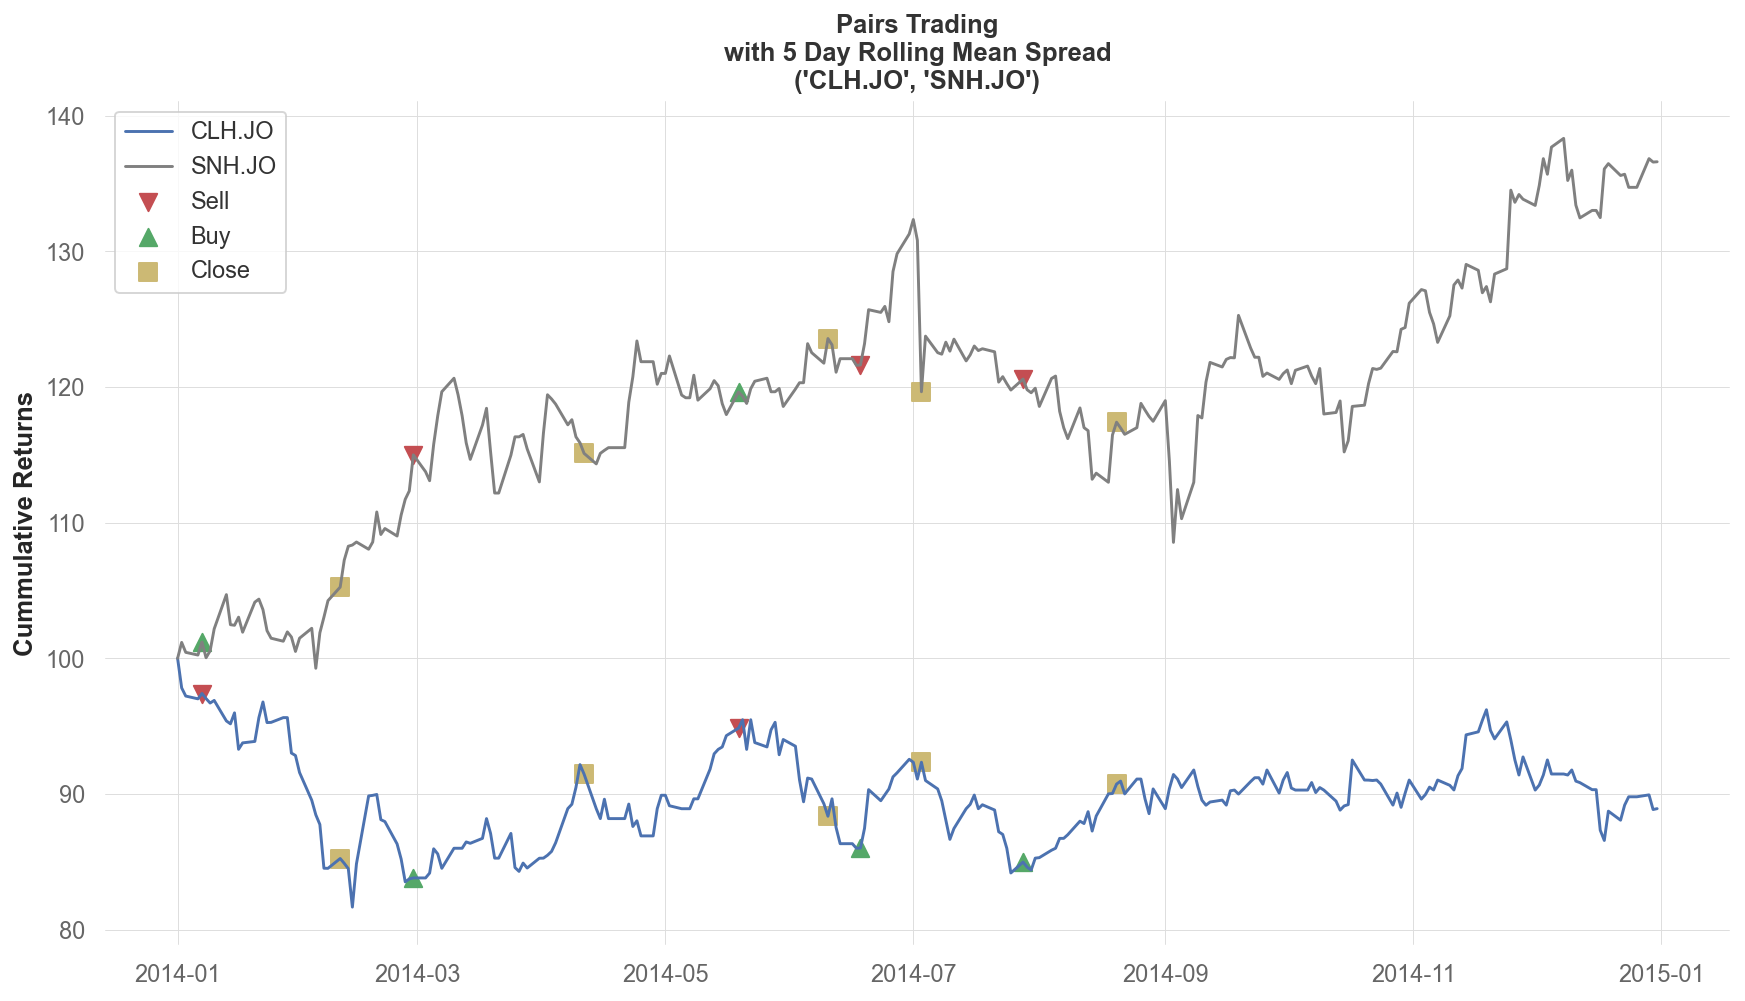

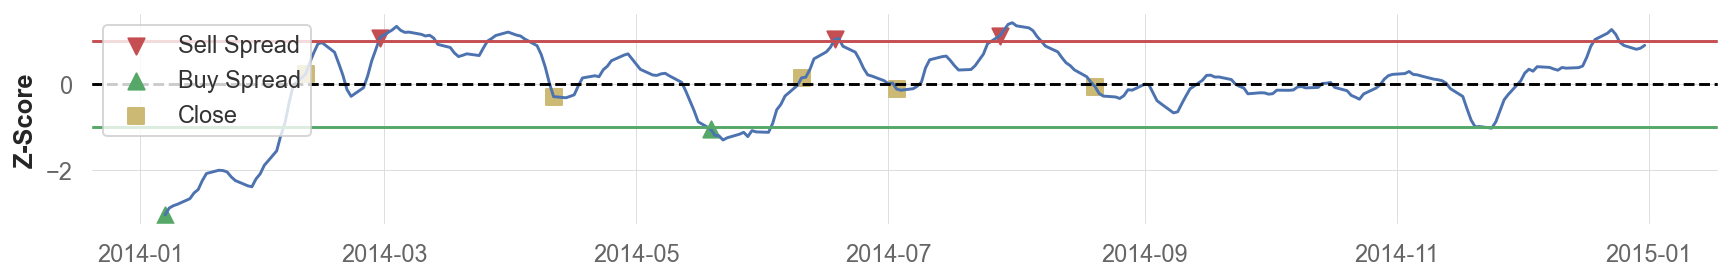

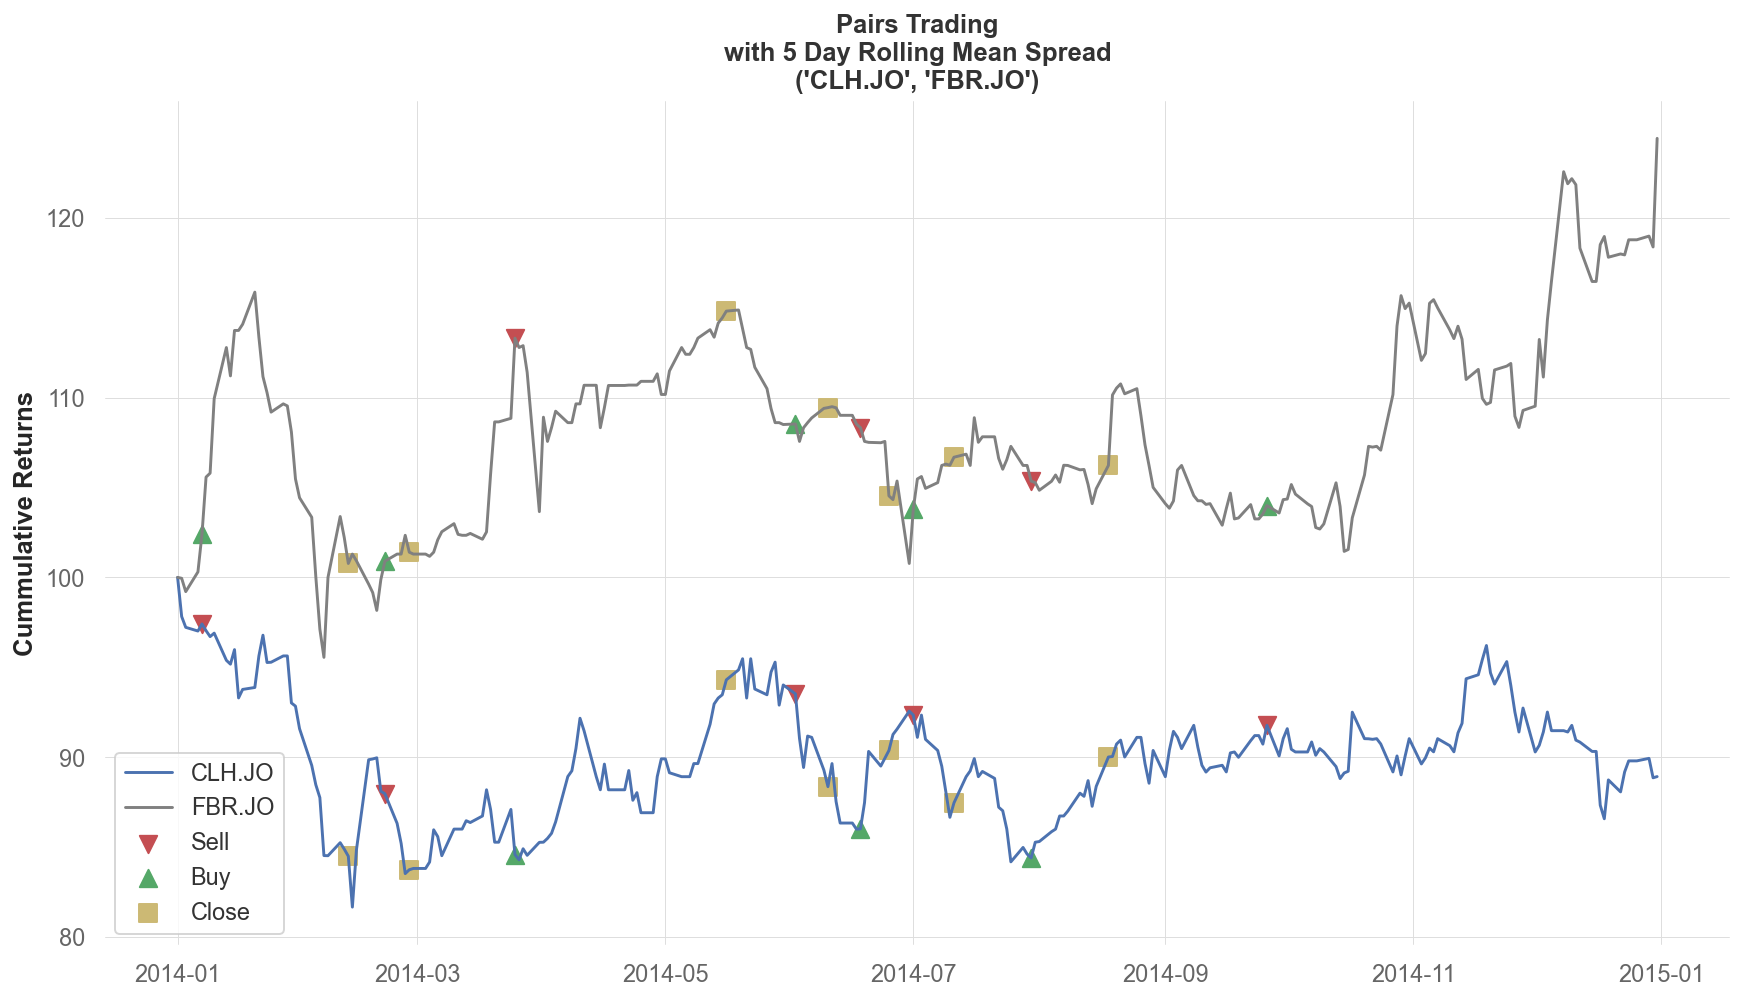

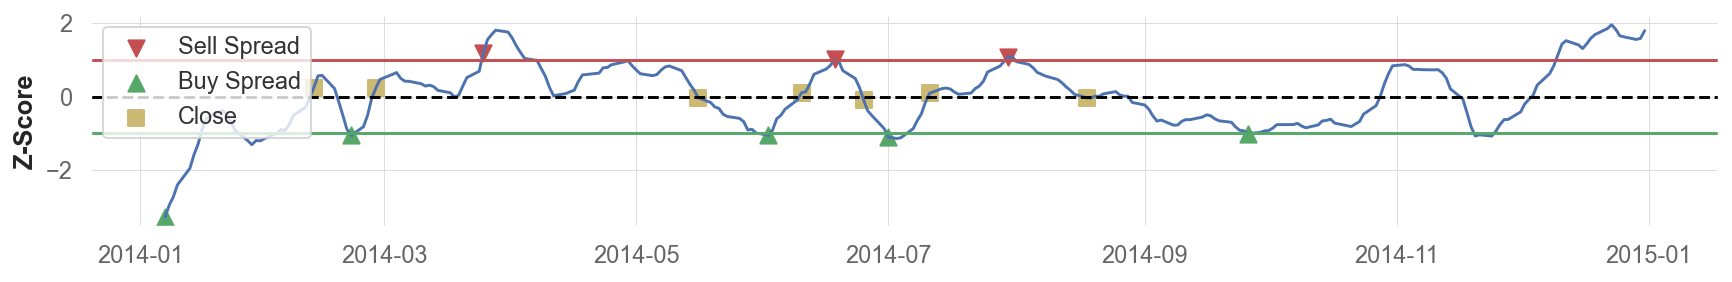

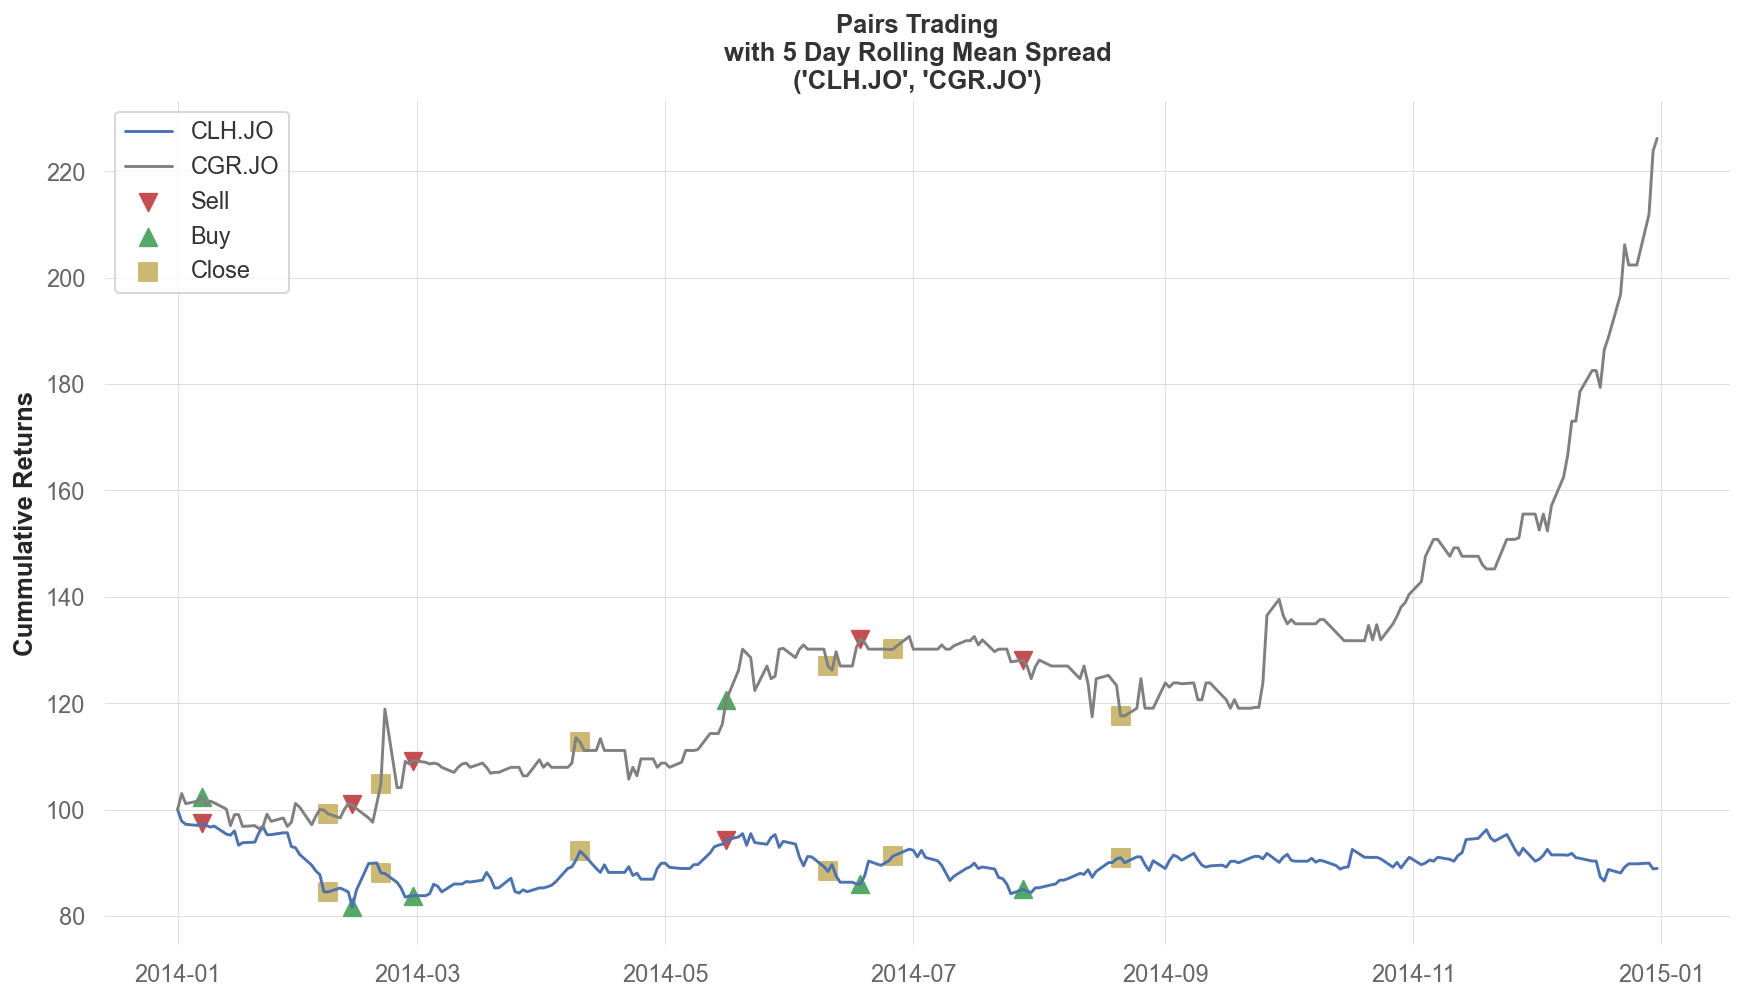

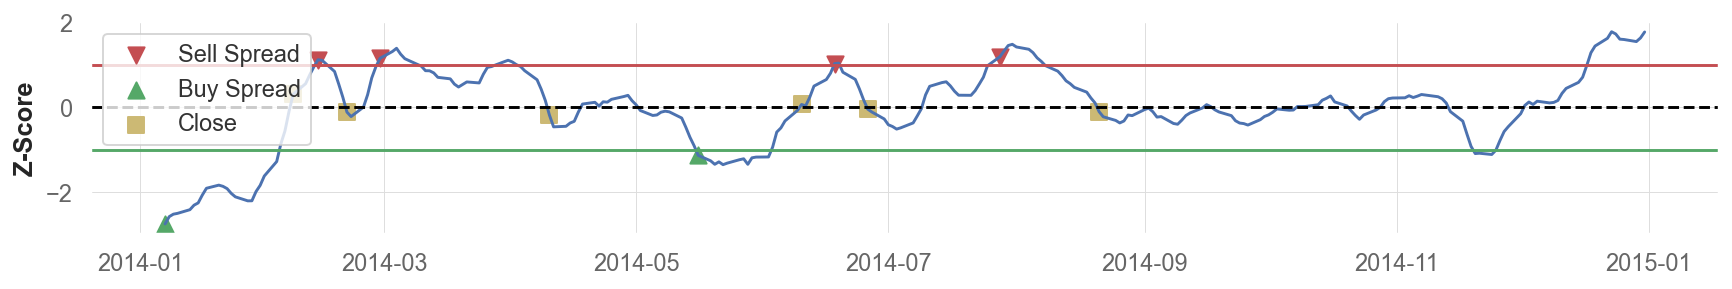

In [46]:
# line plot
for pair in asset_weights.index:
    pairs_trade_plot(stocks, spread, pair)
    zscore_spread_plot(spread, pair, title='')

In [47]:
portfolio_returns = backtest[['Exit','Portfolio Returns']].set_index('Exit')
portfolio_returns.columns = ['Portfolio']

In [48]:
portfolio_metrics = performance_metrics(portfolio_returns)
pd.concat([portfolio_metrics, index_metrics])

Expected Returns  Cummulative Returns  Volatility  Sharpe Ratio  \
Portfolio          0.144694             0.260414    0.197151      6.403707   
Index              0.062715             0.217231    0.135733      1.466372   

           Sortino Ratio  Information Ratio  Skewness  Max Drawdown  \
Portfolio      31.489705          -0.145865  2.804237     -0.030647   
Index           2.262092          -0.022565 -0.119760     -0.100846   

           CVaR at 95%  Pay-Off Ratio  
Portfolio    -0.015418       2.947030  
Index        -0.017851       1.120613

Even though the Portfolio slightly out performed the Index, the Portfolio reletively performed quiet well!

It is important to consider the limitations of the results presented. One important factor to keep in mind is the use of closing prices, which are widely available but may not accurately reflect the prices at which one could realistically trade. This is because closing prices are often the result of an auction and can introduce additional volatility to the data. As a result, the results of pairs trading strategies run on closing price data may be better than they would be in real-world trading. It is worth bearing in mind that this may lead to an overestimation of the potential profitability of the strategy.

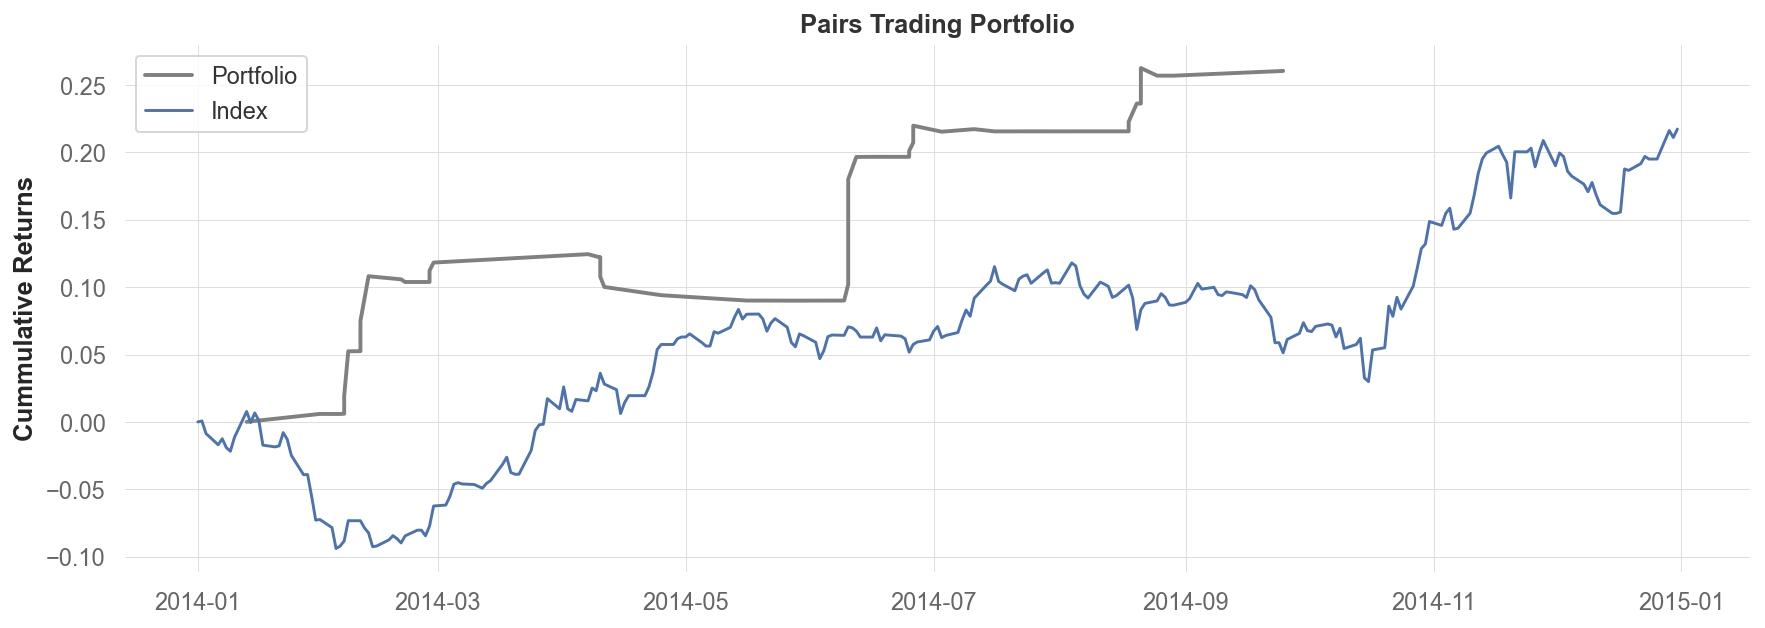

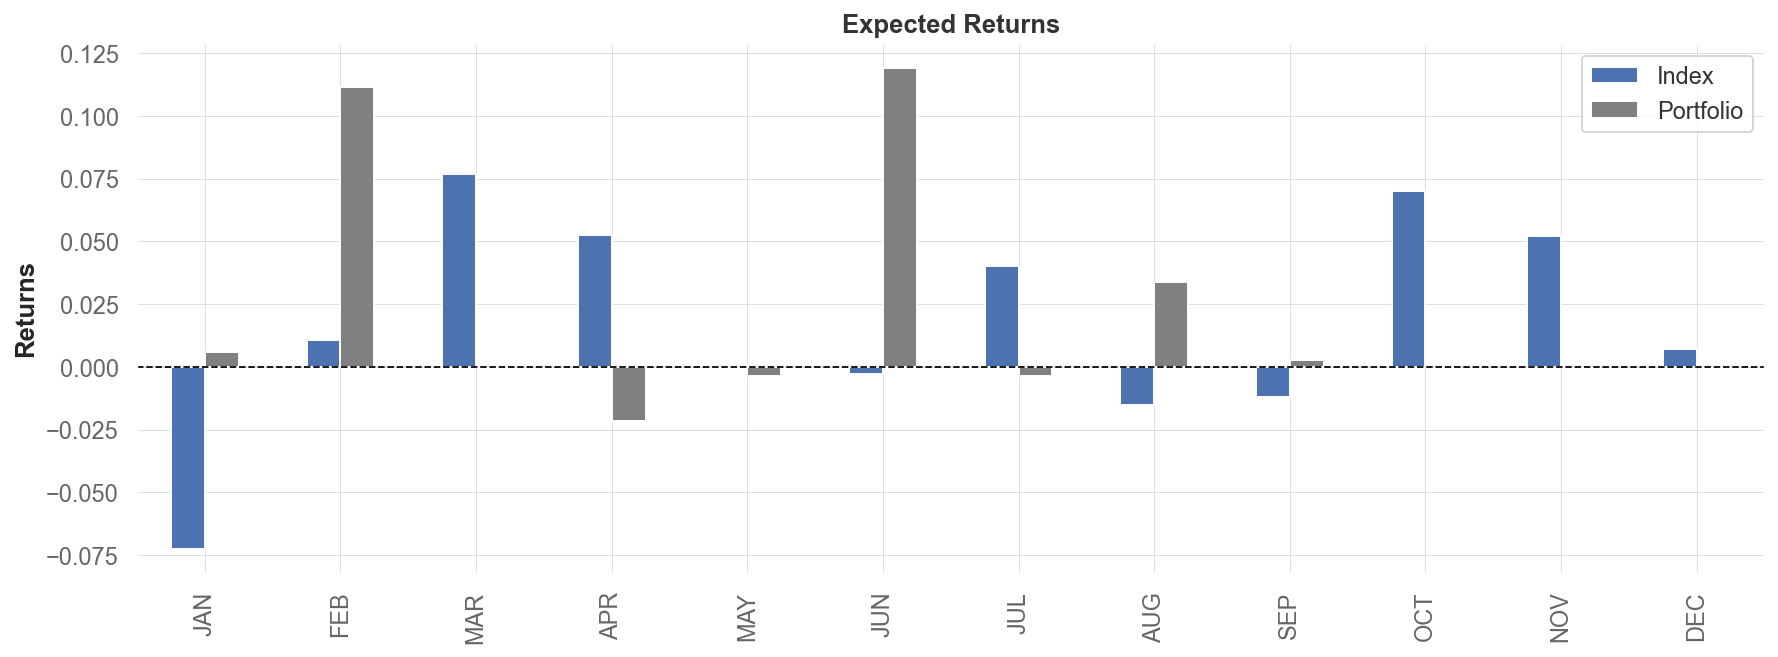

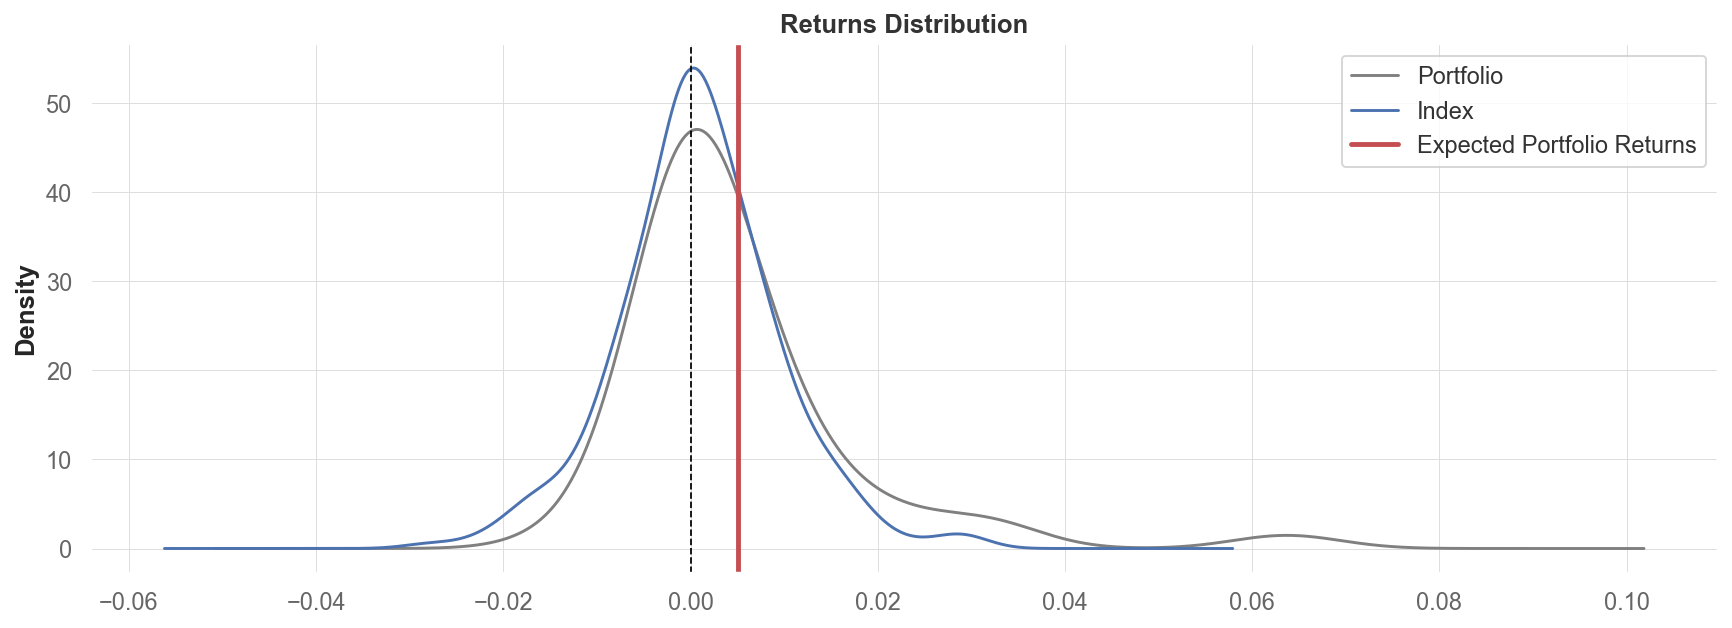

In [49]:
# line plot 
plt.figure(figsize=(15, 5))
plt.title('Pairs Trading Portfolio')
plt.plot(portfolio_returns.compsum(), c='gray', lw=2, label='Portfolio')
plt.plot(index.to_returns().compsum(), c='b', label='Index')
plt.ylabel('Cummulative Returns'), plt.legend()

# bar plot
monthly_r = pd.concat([index.monthly_returns(), portfolio_returns.monthly_returns()])
monthly_r.index = ['Index', 'Portfolio']
monthly_r.drop('EOY', axis=1).T.plot.bar(figsize=(15, 5), color=['b','gray'])
plt.axhline(0, ls='--', lw=0.9, c='black'), plt.title('Expected Returns')
plt.ylabel('Returns');

# KDE plot
pd.concat([portfolio_returns, index.to_returns()]).plot.kde(
    figsize=(15, 5), color=['gray', 'b']), 
plt.axvline(0, ls='--', lw=0.9, c='black'), 
plt.title('Returns Distribution')
plt.axvline(portfolio_returns.mean().values, c='r', lw=2.5, 
            label='Expected Portfolio Returns'), plt.legend();

## Out-of-Sample Backtest

In this section we will assume that the pairs are still cointegrated, the out of sample backtest will be from `2015-01-01` to `2022-01-01`

In [50]:
def get_OutofSampleBacktest(start='2015-01-01', end='2022-01-01'):
    pairs = asset_weights.index
    trading_years = data.loc[start:end].index.year.unique()
    backtest, features = pd.DataFrame(), pd.DataFrame()
    
    # backtest + feature engineering
    for year in trading_years:
        df = data.loc[f'{year}-01-01':f'{year}-12-31']['Adj Close']
        spread = get_spread(df, pairs)
        
        bt = {}
        for pair in pairs:
            bt[pair] = backtest_algo(df, spread, pair)
        bt = pd.concat([bt[pairs] for pairs, vals in bt.items()])
        bt.sort_values('Exit', inplace=True)
        backtest = pd.concat([backtest, bt])
        ft = feature_engineering(spread, bt, pairs)
        features = pd.concat([features, ft])
    
    # portfolio returns
    List = []
    for pair in pairs:
        allocation = asset_weights.loc[{pair}].values
        pair_ = backtest[backtest['Pairs'] == pair]
        pair_['Allocation'] = np.repeat(allocation, len(pair_))
        List.append(pair_)
    backtest = pd.concat(List).sort_values('Exit')
    backtest['Portfolio Returns'] = backtest.eval('Allocation * Returns')
    return backtest, features

In [51]:
backtest, features = get_OutofSampleBacktest()

In [52]:
features.describe()

Returns  Volatility  Sharpe Ratio  Max Drawdown  \
count  56.000000   23.000000     23.000000     56.000000   
mean    0.328599    2.610400     17.466617     -0.015857   
std     0.587870    5.052448     16.491029      0.056864   
min    -0.228627    0.296702    -14.336032     -0.356121   
25%    -0.000456    0.647225      8.380658      0.000000   
50%     0.155204    1.006972     12.750610      0.000000   
75%     0.402528    2.723882     27.854199      0.000000   
max     3.305041   25.068971     54.774938      0.000000   

       Average Holding Period  No. of Trades  Buy Positions  Sell Positions  \
count               56.000000      56.000000      56.000000       56.000000   
mean                97.857143       1.660714       0.821429        0.839286   
std                 44.145803       1.014025       0.855084        0.681623   
min                 23.000000       1.000000       0.000000        0.000000   
25%                 61.750000       1.000000       0.000000        0.000000   
50%                 84.500000       1.000000       1.000000        1.000000   
75%                138.250000       2.000000       1.000000        1.000000   
max                181.000000       5.000000       3.000000        3.000000   

         P-Value  Correlation  
count  56.000000    56.000000  
mean    0.435460     0.018569  
std     0.309672     0.052679  
min     0.002504    -0.061995  
25%     0.159766    -0.005756  
50%     0.379269     0.017930  
75%     0.693093     0.043186  
max     0.951655     0.103948

Based on the feature table, we identified several stock pairs with a stationary spread in our out-of-sample backtest, as indicated by the P-Value. However, the strategy did not perform as well in the out-of-sample backtest as it did in the in-sample backtest. Over a period of 8 years, the strategy only resulted in 56 trades with an average holding period of more than 100 days.

In [53]:
portfolio_returns = backtest[['Exit','Portfolio Returns']].set_index('Exit')
portfolio_returns.columns = ['Out-of-Sample Portfolio']
performance_metrics(portfolio_returns)

Expected Returns  Cummulative Returns  Volatility  \
Out-of-Sample Portfolio          1.805768             7.308258    1.461165   

                         Sharpe Ratio  Sortino Ratio  Information Ratio  \
Out-of-Sample Portfolio      4.548833      28.993151            0.28655   

                         Skewness  Max Drawdown  CVaR at 95%  Pay-Off Ratio  
Out-of-Sample Portfolio  4.092478     -0.085842    -0.125025       2.891924

# ____

# About Me
Email: ndhlovthabang1@gmail.com

LinkedIn: http://www.linkedin.com/in/thabangndhlovu

# Disclaimer
This notebook is entirely for educational purposes. None of the information in this notebook constitutes a recommendation that any particular portfolio of securities is suitable for any particular person. All trading strategies are used at your own risk. Moreover, this analysis is in-sample and the study period was specifically chosen for this trading strategy.

# References
Govender K, "Statistical Arbitrage in South African Financial Markets", University of Cape Town (2011). [Accessed (2022)](https://open.uct.ac.za/handle/11427/12241)

Mackenzie D, Margenot M, "Quantopian Lecture Series: Introduction to Pairs Trading" [Accessed (2022)](https://github.com/quantopian/research_public).

Vidyamurthy G, "Pairs Trading Quantitative Methods and Analysis", John Wiley & Sons (2004).

Rubppert D, Mattenson D. S, "Statistics and Data Analysis for Financial Engineering 2nd Edition", Springer (2015). [Accessed (2022)](https://link.springer.com/book/10.1007/978-1-4939-2614-5)

"Python for Finance", Pierian Data (2017).